In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output

from tqdm import tqdm
from nba_api.stats.static import players, teams
from nba_api.stats.library.parameters import SeasonAll


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_absolute_error, mean_squared_error

In C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Jordan Nishimura\Anaconda3\lib\site-

In [3]:
pd.options.display.max_columns=200

## Compiling and Cleaning Data

In [4]:
seasons = ["20{}-{}".format(x, x+1) for x in range(10, 21)]
print(seasons)
def gather_data(seasons = seasons):
    full_player_data = []
    for season in seasons:
        player_gls = pd.read_csv('./data/player_gamelogs_{}.csv'.format(season), dtype={'GAME_ID':'object'})
        player_gls_adv = pd.read_csv('./data/player_advanced_boxscores_{}.csv'.format(season), dtype={'GAME_ID':'object'})
        player_gls_scoring = pd.read_csv('./data/player_scoring_boxscores_{}.csv'.format(season), dtype={'GAME_ID':'object'})
        player_gls_tracking = pd.read_csv('./data/player_tracking_boxscores_{}.csv'.format(season), dtype={'GAME_ID':'object'})
        
        player_gls = player_gls[['SEASON_YEAR', 'PLAYER_ID', 'PLAYER_NAME', 'TEAM_ID',
       'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID', 'GAME_DATE', 'MATCHUP',
       'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM',
       'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK',
       'BLKA', 'PF', 'PFD', 'PTS', 'PLUS_MINUS']]

        player_full = pd.merge(player_gls, player_gls_adv, how='left', on=['GAME_ID', 'PLAYER_ID'], suffixes=['', '_x'])
        player_full = pd.merge(player_full, player_gls_scoring, how='left', on=['GAME_ID', 'PLAYER_ID'], suffixes=['', '_x'])
        player_full = pd.merge(player_full, player_gls_tracking, how='left', on=['GAME_ID', 'PLAYER_ID'], suffixes=['', '_x'])
    
        # drop unnecessary columns
        player_full = player_full.drop(columns = ['PLAYER_ID', 'TEAM_ID', 'TEAM_NAME', 'TEAM_ID_x',
                         'TEAM_ABBREVIATION_x','TEAM_CITY','PLAYER_NAME_x','START_POSITION',
                          'COMMENT','MIN_x','TEAM_ID_x', 'TEAM_ABBREVIATION_x','TEAM_CITY_x', 
                          'PLAYER_NAME_x', 'START_POSITION_x', 'COMMENT_x', 'MIN_x', 
                         'TEAM_ID_x', 'TEAM_ABBREVIATION_x', 'TEAM_CITY_x', 'PLAYER_NAME_x', 
                          'START_POSITION_x', 'COMMENT_x', 'MIN_x', 'AST_x', 'FG_PCT_x',
                         'FG_PCT', 'FG3_PCT', 'FT_PCT', 'E_NET_RATING', 'NET_RATING', 
                         'AST_PCT', 'OREB_PCT', 'DREB_PCT', 'REB_PCT', 'EFG_PCT', 'TS_PCT', 
                         'PCT_FGA_2PT', 'PCT_FGA_3PT', 'PCT_PTS_FT', 'CFG_PCT',
                        'UFG_PCT', 'DFG_PCT'], 
                       errors= 'ignore')

        # Convert date to datetime
        player_full['GAME_DATE'] = pd.to_datetime(player_full['GAME_DATE'])
        
        # Convert W/L to a binary 1/0 for win/loss
        player_full['WL'] = (player_full['WL'].str[0] == 'W').astype(int)
        
        # Add a binary home_game feature
        player_full['HOME_GAME'] = 0 
        player_full['HOME_GAME'] = (player_full['MATCHUP'].str[:6] == player_full['TEAM_ABBREVIATION'].str[:] + ' vs').astype(int)
        
        # convert the percentages into raw numbers (because we will be averaging them, we don't want to average percentages)
        # for example, percentage of points from midrange will be points scored from midrange
        player_full['FG2M'] = player_full['FGM'] - player_full['FG3M']
        player_full['FG2A'] = player_full['FGA'] - player_full['FG3A']
        player_full['PTS_2PT'] = (player_full['PTS'] * player_full['PCT_PTS_2PT']).astype('int8')
        player_full['PTS_2PT_MR'] = (player_full['PTS'] * player_full['PCT_PTS_2PT_MR']).astype('int8')
        player_full['PTS_3PT'] = (player_full['PTS'] * player_full['PCT_PTS_3PT']).astype('int8')
        player_full['PTS_FB'] = (player_full['PTS'] * player_full['PCT_PTS_FB']).astype('int8')
        player_full['PTS_OFF_TOV'] = (player_full['PTS'] * player_full['PCT_PTS_OFF_TOV']).astype('int8')
        player_full['PTS_PAINT'] = (player_full['PTS'] * player_full['PCT_PTS_PAINT']).astype('int8')
        player_full['AST_2PM'] = (player_full['FG2M'] * player_full['PCT_AST_2PM']).astype('int8')
        player_full['UAST_2PM'] = (player_full['FG2M'] * player_full['PCT_UAST_2PM']).astype('int8')
        player_full['AST_3PM'] = (player_full['FG3M'] * player_full['PCT_AST_3PM']).astype('int8')
        player_full['UAST_3PM'] = (player_full['FG3M'] * player_full['PCT_UAST_3PM']).astype('int8')



        player_full = player_full.drop(columns = ['PCT_PTS_2PT', 'PCT_PTS_2PT_MR', 'PCT_PTS_3PT', 
                                                  'PCT_PTS_FB', 'PCT_PTS_OFF_TOV', 'PCT_PTS_PAINT',
                                                  'PCT_AST_2PM', 'PCT_UAST_2PM', 'PCT_AST_3PM',
                                                  'PCT_UAST_3PM', 'PCT_AST_FGM', 'PCT_UAST_FGM', 
                                                  'FGM', 'FGA', 'AST_TOV', 'USG_PCT', 'PACE',
                                                  'PACE_PER40', ], errors='ignore')
        
        
        full_player_data.append(player_full)
        
        
    
    player_df = pd.concat(full_player_data)
    
    
    player_df['home_team_abbr'] = player_df.apply(lambda row: row['TEAM_ABBREVIATION'] if row['HOME_GAME'] == 1 else row['MATCHUP'][-3:], axis=1)
    player_df['away_team_abbr'] = player_df.apply(lambda row: row['TEAM_ABBREVIATION'] if row['HOME_GAME'] == 0 else row['MATCHUP'][-3:], axis=1)
    
    player_df[['home_team_abbr', 'away_team_abbr']] = player_df[['home_team_abbr', 'away_team_abbr']].replace({'NOH':'NOP',
                                                                                                               'NJN':'BKN'})
    
    # Reorder columns
    player_df = player_df[['SEASON_YEAR', 'TEAM_ABBREVIATION', 'PLAYER_NAME', 'home_team_abbr', 
                           'away_team_abbr', 'GAME_ID', 'GAME_DATE', 'MATCHUP',
                           'WL', 'HOME_GAME', 'MIN', 'FG3M', 'FG3A', 'FTM', 
                           'FTA', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL',
                           'BLK', 'BLKA', 'PF', 'PFD', 'PTS', 'PLUS_MINUS', 
                           'E_OFF_RATING', 'OFF_RATING', 'E_DEF_RATING',
                           'DEF_RATING', 'AST_RATIO', 'TM_TOV_PCT', 'E_USG_PCT',
                           'E_PACE', 'POSS', 'PIE', 'SPD', 'DIST', 'ORBC', 
                           'DRBC', 'RBC', 'TCHS', 'SAST', 'FTAST', 'PASS', 
                           'CFGM', 'CFGA', 'UFGM', 'UFGA', 'DFGM', 'DFGA', 
                           'FG2M', 'FG2A', 'PTS_2PT', 'PTS_2PT_MR', 'PTS_3PT',
                           'PTS_FB', 'PTS_OFF_TOV', 'PTS_PAINT', 'AST_2PM',
                           'UAST_2PM', 'AST_3PM', 'UAST_3PM']]
    
    return player_df

player_df = gather_data(seasons)

['2010-11', '2011-12', '2012-13', '2013-14', '2014-15', '2015-16', '2016-17', '2017-18', '2018-19', '2019-20', '2020-21']


In [83]:
player_df

,SEASON_YEAR,TEAM_ABBREVIATION,PLAYER_NAME,home_team_abbr,away_team_abbr,GAME_ID,GAME_DATE,MATCHUP,WL,HOME_GAME,MIN,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,AST_RATIO,TM_TOV_PCT,E_USG_PCT,E_PACE,POSS,PIE,SPD,DIST,ORBC,DRBC,RBC,TCHS,SAST,FTAST,PASS,CFGM,CFGA,UFGM,UFGA,DFGM,DFGA,FG2M,FG2A,PTS_2PT,PTS_2PT_MR,PTS_3PT,PTS_FB,PTS_OFF_TOV,PTS_PAINT,AST_2PM,UAST_2PM,AST_3PM,UAST_3PM
0,2010-11,MIL,Corey Maggette,OKC,MIL,0021001225,2011-04-13,MIL @ OKC,1,0,18.776667,0,0,6,6,0,1,1,2,2,1,0,0,2,3,12,2,111.0,107.7,105.4,105.3,16.7,16.7,0.239,96.89,39,0.139,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,3,5,6,3,0,2,0,2,3,0,0,0
1,2010-11,NOH,Jarrett Jack,DAL,NOP,0021001223,2011-04-13,NOH @ DAL,0,0,28.658333,1,1,5,6,0,0,0,7,1,0,1,0,2,4,22,-22,100.3,101.8,137.0,136.2,28.0,4.0,0.296,95.91,56,0.144,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,7,14,13,6,2,2,0,8,2,4,1,0
2,2010-11,NJN,Jordan Farmar,CHI,BKN,0021001222,2011-04-13,NJN @ CHI,0,0,38.166667,2,6,5,6,0,4,4,12,4,0,2,0,1,4,21,7,107.9,112.7,102.8,101.4,35.3,11.8,0.274,91.28,71,0.198,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,5,9,9,3,6,1,6,6,0,5,1,1
3,2010-11,NYK,Amar'e Stoudemire,BOS,NYK,0021001216,2011-04-13,NYK @ BOS,0,0,20.450000,0,0,2,3,2,2,4,1,2,0,1,0,1,4,14,-3,107.6,112.5,107.5,117.1,5.3,10.5,0.384,101.49,40,0.072,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,6,15,11,4,0,0,0,7,1,4,0,0
4,2010-11,OKC,Byron Mullens,OKC,MIL,0021001225,2011-04-13,OKC vs. MIL,0,1,29.178333,0,0,2,4,1,4,5,0,2,1,0,1,2,2,10,-22,90.1,90.0,130.8,128.8,0.0,15.4,0.191,97.12,60,0.041,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,4,9,8,0,0,1,4,8,3,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6900,2020-21,BKN,Landry Shamet,BKN,GSW,0022000001,2020-12-22,BKN vs. GSW,1,1,19.716667,1,4,3,4,0,1,1,0,2,1,0,0,3,2,6,12,110.8,106.5,75.4,80.4,0.0,25.0,0.169,113.59,46,-0.017,4.56,1.59,1,1,1,31,1,0,23,0,1,1,3,1,2,0,0,0,0,3,3,4,0,0,0,1,0
6901,2020-21,BKN,Timothe Luwawu-Cabarrot,BKN,GSW,0022000001,2020-12-22,BKN vs. GSW,1,1,6.600000,1,3,0,0,1,1,2,0,1,0,0,0,2,0,5,-9,85.7,80.0,142.3,140.0,0.0,14.3,0.412,104.58,15,-0.016,4.71,0.55,1,2,3,13,0,0,6,1,2,1,4,0,0,1,3,2,0,3,0,0,2,0,1,1,0
6902,2020-21,BKN,Rodions Kurucs,BKN,GSW,0022000001,2020-12-22,BKN vs. GSW,1,1,6.600000,1,1,0,0,0,1,1,0,0,0,0,0,0,0,3,-9,85.7,80.0,142.3,140.0,0.0,0.0,0.059,104.58,15,0.129,4.57,0.53,0,1,1,8,0,0,7,0,0,1,1,1,1,0,0,0,0,3,0,0,0,0,0,1,0
6903,2020-21,LAL,Alex Caruso,LAL,LAC,0022000002,2020-12-22,LAL vs. LAC,0,1,16.666667,1,4,0,0,0,2,2,1,3,0,0,0,0,1,3,3,108.1,108.6,89.6,97.2,11.1,33.3,0.210,106.91,35,-0.021,4.50,1.35,0,6,6,33,0,0,25,0,1,1,4,1,1,0,1,0,0,3,0,0,0,0,0,1,0


In [6]:
test = player_df.loc[player_df['GAME_ID'] == '0022000015']
home_test = test.loc[test['HOME_GAME'] == 1].sort_values('MIN', ascending=False)
# home_test.iloc[:12, 9:].values.reshape(1, -1)
home_test
away_test = test.loc[test['HOME_GAME'] == 0].sort_values('MIN', ascending=False)
away_test

,SEASON_YEAR,TEAM_ABBREVIATION,PLAYER_NAME,home_team_abbr,away_team_abbr,GAME_ID,GAME_DATE,MATCHUP,WL,HOME_GAME,MIN,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,AST_RATIO,TM_TOV_PCT,E_USG_PCT,E_PACE,POSS,PIE,SPD,DIST,ORBC,DRBC,RBC,TCHS,SAST,FTAST,PASS,CFGM,CFGA,UFGM,UFGA,DFGM,DFGA,FG2M,FG2A,PTS_2PT,PTS_2PT_MR,PTS_3PT,PTS_FB,PTS_OFF_TOV,PTS_PAINT,AST_2PM,UAST_2PM,AST_3PM,UAST_3PM
6676,2020-21,ATL,Solomon Hill,CHI,ATL,0022000015,2020-12-23,ATL @ CHI,1,0,28.400000,0,3,0,0,0,3,3,0,3,0,1,0,2,0,0,-8,90.9,90.3,100.3,101.6,0.0,50.0,0.089,105.97,62,-0.051,4.16,2.11,1,8,9,41,0,0,33,0,0,0,3,2,3,0,0,0,0,0,0,0,0,0,0,0,0
6782,2020-21,ATL,Kevin Huerter,CHI,ATL,0022000015,2020-12-23,ATL @ CHI,1,0,27.050000,2,6,1,2,0,2,2,4,0,1,0,0,2,1,11,0,108.6,106.6,104.2,103.2,26.7,0.0,0.172,108.42,61,0.082,4.27,2.06,1,2,3,47,2,0,36,1,2,3,8,0,0,2,4,4,2,5,5,0,2,1,1,2,0
6791,2020-21,ATL,Trae Young,CHI,ATL,0022000015,2020-12-23,ATL @ CHI,1,0,25.963333,5,6,12,14,2,4,6,7,4,0,0,0,1,9,37,30,143.4,142.4,93.4,96.4,25.0,14.3,0.336,107.60,59,0.362,4.22,1.96,2,5,7,71,0,0,45,4,4,6,8,1,2,5,6,9,1,14,1,7,7,0,5,0,5
6617,2020-21,ATL,De'Andre Hunter,CHI,ATL,0022000015,2020-12-23,ATL @ CHI,1,0,25.900000,1,1,0,0,0,3,3,1,2,0,0,0,3,0,11,40,136.7,141.0,78.0,76.7,11.1,22.2,0.121,112.94,61,0.082,4.24,1.94,1,4,5,25,1,0,16,4,4,1,2,2,2,4,5,7,0,3,0,4,7,3,1,1,0
6806,2020-21,ATL,Bogdan Bogdanovic,CHI,ATL,0022000015,2020-12-23,ATL @ CHI,1,0,24.933333,3,8,2,3,0,7,7,2,2,1,0,1,2,1,15,0,105.0,105.1,102.7,101.6,11.8,11.8,0.246,114.93,59,0.131,4.40,1.96,1,11,12,50,1,0,36,0,1,5,11,1,2,2,4,4,0,9,4,4,4,1,1,3,0
6802,2020-21,ATL,Danilo Gallinari,CHI,ATL,0022000015,2020-12-23,ATL @ CHI,1,0,24.433333,1,2,4,4,0,4,4,3,3,0,0,0,2,4,13,31,144.4,149.1,89.5,89.5,21.4,21.4,0.187,111.74,55,0.119,3.91,1.72,0,5,5,42,0,0,32,2,2,2,4,2,3,3,4,6,2,3,0,0,4,2,0,1,0
6817,2020-21,ATL,Cam Reddish,CHI,ATL,0022000015,2020-12-23,ATL @ CHI,1,0,23.766667,1,3,2,2,1,5,6,0,1,2,0,0,3,1,15,27,137.2,139.6,87.1,87.0,0.0,7.7,0.228,108.94,53,0.138,4.52,1.91,1,7,8,30,0,0,15,3,5,3,6,2,2,5,8,10,0,3,4,6,10,2,3,1,0
6686,2020-21,ATL,Bruno Fernando,CHI,ATL,0022000015,2020-12-23,ATL @ CHI,1,0,18.133333,0,0,1,2,3,4,7,1,3,2,0,0,3,1,5,-1,80.1,80.0,85.5,84.6,12.5,37.5,0.156,103.98,40,0.133,4.18,1.35,6,6,11,31,0,0,25,1,2,1,1,1,4,2,3,4,0,0,2,4,4,2,0,0,0
6840,2020-21,ATL,John Collins,CHI,ATL,0022000015,2020-12-23,ATL @ CHI,1,0,18.050000,0,2,2,2,0,4,4,2,0,0,2,1,4,5,14,21,144.0,147.5,93.8,90.5,16.7,0.0,0.227,108.34,40,0.165,4.28,1.38,1,8,9,30,0,0,19,5,7,1,3,2,5,6,8,11,2,0,4,2,9,4,1,0,0
6703,2020-21,ATL,Brandon Goodwin,CHI,ATL,0022000015,2020-12-23,ATL @ CHI,1,0,13.236667,1,3,0,0,0,1,1,4,1,0,0,1,4,0,3,-16,58.8,59.3,111.4,110.3,44.4,11.1,0.160,101.39,27,0.000,4.02,0.96,1,1,2,40,0,0,32,0,1,1,3,1,1,0,1,0,0,3,0,0,0,0,0,0,1


In [7]:
test = player_df.loc[player_df['SEASON_YEAR'] == '2018-19']

home = test.loc[test['HOME_GAME'] == 1]
home.loc[home['GAME_ID'] == '0021801228']

away = test.loc[test['HOME_GAME'] == 0]

away.loc[away['GAME_ID'] == '0021801228']

,SEASON_YEAR,TEAM_ABBREVIATION,PLAYER_NAME,home_team_abbr,away_team_abbr,GAME_ID,GAME_DATE,MATCHUP,WL,HOME_GAME,MIN,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,AST_RATIO,TM_TOV_PCT,E_USG_PCT,E_PACE,POSS,PIE,SPD,DIST,ORBC,DRBC,RBC,TCHS,SAST,FTAST,PASS,CFGM,CFGA,UFGM,UFGA,DFGM,DFGA,FG2M,FG2A,PTS_2PT,PTS_2PT_MR,PTS_3PT,PTS_FB,PTS_OFF_TOV,PTS_PAINT,AST_2PM,UAST_2PM,AST_3PM,UAST_3PM
3,2018-19,MIN,Dario Saric,DEN,MIN,0021801228,2019-04-10,MIN @ DEN,0,0,29.255000,0,5,3,3,1,6,7,3,1,0,0,1,3,2,11,-1,93.8,93.2,101.3,94.9,16.7,5.6,0.236,93.46,59,0.081,4.03,2.12,5,12,17,62,0,0,44,3,4,1,9,2,6,4,8,7,2,0,0,0,5,2,2,0,0
51,2018-19,MIN,Tyus Jones,DEN,MIN,0021801228,2019-04-10,MIN @ DEN,0,0,34.266667,0,2,0,0,0,1,1,8,0,0,0,0,4,0,8,-19,84.3,83.1,110.5,108.3,40.0,0.0,0.160,98.47,71,0.040,4.29,2.61,0,4,4,91,1,0,74,3,9,1,3,2,2,4,10,8,2,0,4,4,6,2,2,0,0
65,2018-19,MIN,Andrew Wiggins,DEN,MIN,0021801228,2019-04-10,MIN @ DEN,0,0,35.983333,3,6,0,1,1,4,5,4,2,0,0,0,1,3,25,-8,89.9,90.4,103.2,98.7,15.4,7.7,0.277,96.82,73,0.167,3.80,2.45,4,6,9,56,2,0,31,4,6,7,14,1,4,8,14,16,4,9,3,0,12,1,7,3,0
81,2018-19,MIN,Gorgui Dieng,DEN,MIN,0021801228,2019-04-10,MIN @ DEN,0,0,34.445000,2,4,0,0,4,7,11,2,5,3,0,1,5,2,18,-19,88.9,87.7,114.3,112.2,7.4,18.5,0.321,100.75,73,0.072,4.07,2.50,5,12,17,70,0,0,46,4,8,4,12,4,4,6,16,12,3,5,0,0,7,3,3,2,0
93,2018-19,MIN,Josh Okogie,DEN,MIN,0021801228,2019-04-10,MIN @ DEN,0,0,17.116667,0,0,0,0,0,1,1,1,0,1,0,1,1,1,0,-3,86.1,83.8,97.8,94.4,25.0,0.0,0.073,99.22,37,-0.017,4.28,1.30,1,3,4,15,0,0,11,0,2,0,1,0,1,0,3,0,0,0,0,0,0,0,0,0,0
96,2018-19,MIN,Jared Terrell,DEN,MIN,0021801228,2019-04-10,MIN @ DEN,0,0,5.716667,0,1,1,2,0,0,0,0,0,0,0,0,1,1,1,2,127.5,118.2,111.3,100.0,0.0,0.0,0.179,84.30,11,-0.098,4.35,0.45,0,0,0,11,0,0,9,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
112,2018-19,MIN,C.J. Williams,DEN,MIN,0021801228,2019-04-10,MIN @ DEN,0,0,17.600000,2,2,0,0,0,1,1,1,0,0,0,0,2,0,6,11,135.6,137.5,96.2,97.1,33.3,0.0,0.060,91.04,32,0.078,4.15,1.30,0,2,2,16,1,0,14,0,0,2,2,2,3,0,0,0,0,6,0,0,0,0,0,2,0
153,2018-19,MIN,Anthony Tolliver,DEN,MIN,0021801228,2019-04-10,MIN @ DEN,0,0,21.083333,1,5,0,0,0,2,2,3,1,1,0,0,2,1,3,5,110.0,111.6,99.3,100.0,33.3,11.1,0.129,98.99,43,0.024,4.22,1.59,0,4,4,31,0,0,24,0,1,1,4,2,4,0,0,0,0,3,0,0,0,0,0,1,0
203,2018-19,MIN,Cameron Reynolds,DEN,MIN,0021801228,2019-04-10,MIN @ DEN,0,0,25.950000,5,7,0,0,0,6,6,1,0,0,0,0,3,2,19,6,114.0,117.6,109.6,105.9,8.3,0.0,0.201,94.26,51,0.188,4.28,2.01,2,6,7,32,0,0,21,2,2,5,9,0,0,2,4,4,1,14,0,6,1,1,1,5,0
220,2018-19,MIN,Keita Bates-Diop,DEN,MIN,0021801228,2019-04-10,MIN @ DEN,0,0,18.583333,0,0,0,0,1,6,7,1,1,1,0,1,0,0,4,6,102.3,100.0,81.4,82.9,16.7,16.7,0.142,90.20,35,0.179,4.05,1.35,1,8,9,26,0,0,20,2,4,0,0,0,0,2,4,4,0,0,0,2,4,2,0,0,0


In [8]:
test = player_df.loc[player_df['GAME_ID'] == '0021801220']
home_team = test.loc[test['HOME_GAME'] == 1].sort_values('MIN', ascending=False)

home_matchup_info = home_team[['SEASON_YEAR', 'TEAM_ABBREVIATION',
                               'home_team_abbr', 'away_team_abbr',
                               'GAME_ID', 'GAME_DATE', 'MATCHUP',
                               'WL', 'HOME_GAME']].iloc[0].values.reshape(1, -1)

home_matchup_info
home_team.iloc[:12, 10:]

,MIN,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,AST_RATIO,TM_TOV_PCT,E_USG_PCT,E_PACE,POSS,PIE,SPD,DIST,ORBC,DRBC,RBC,TCHS,SAST,FTAST,PASS,CFGM,CFGA,UFGM,UFGA,DFGM,DFGA,FG2M,FG2A,PTS_2PT,PTS_2PT_MR,PTS_3PT,PTS_FB,PTS_OFF_TOV,PTS_PAINT,AST_2PM,UAST_2PM,AST_3PM,UAST_3PM
26,35.816667,1,2,3,4,9,16,25,6,3,0,1,1,2,5,20,9,118.6,122.9,111.6,116.3,23.1,11.5,0.194,113.48,83,0.193,4.23,2.75,14,19,32,88,0,0,65,7,12,1,3,3,6,7,13,14,0,3,2,2,14,4,2,1,0
14,33.700000,1,7,10,11,2,3,5,11,6,2,0,2,0,10,23,18,128.6,133.3,111.6,111.7,28.2,15.4,0.292,112.47,78,0.120,4.30,2.63,7,6,12,95,1,0,62,4,6,2,12,1,1,5,11,10,0,2,6,4,10,1,4,0,1
205,33.616667,5,8,2,3,0,5,5,2,1,0,1,1,2,2,23,9,124.2,129.3,112.5,115.8,9.5,4.8,0.206,111.63,75,0.103,3.91,2.39,1,6,7,41,0,0,19,2,5,6,12,2,3,3,9,6,0,14,0,0,6,0,2,5,0
6,30.866667,2,6,6,8,6,4,10,3,0,0,3,1,3,4,20,13,124.1,129.6,112.3,108.2,12.5,0.0,0.236,112.34,71,0.100,4.08,2.30,9,10,19,54,1,0,33,0,4,6,13,3,7,4,11,8,0,6,0,0,8,4,0,2,0
213,30.366667,5,6,0,0,1,4,5,3,3,1,1,0,4,0,17,6,123.7,129.0,118.0,118.6,21.4,21.4,0.128,112.45,69,0.109,4.20,2.33,1,6,7,31,1,0,21,1,2,5,6,5,6,1,2,2,0,14,0,2,2,0,1,4,1
218,20.116667,0,1,3,3,1,1,2,1,0,1,0,0,5,2,11,-11,107.0,110.9,133.2,134.8,10.0,0.0,0.162,112.43,46,0.068,4.28,1.59,3,1,4,27,0,0,18,2,4,2,4,3,4,4,7,7,0,0,2,0,7,4,0,0,0
169,17.066667,2,6,1,2,0,2,2,2,1,0,0,1,2,1,7,-16,101.3,105.0,153.4,148.7,14.3,7.1,0.243,111.49,40,-0.014,4.16,1.33,1,3,4,26,0,1,14,0,5,2,5,2,4,0,4,0,0,5,0,0,0,0,0,1,1
145,12.870000,1,1,2,2,1,2,3,0,2,1,0,0,2,1,7,-8,116.3,110.3,126.6,125.0,0.0,33.3,0.179,110.25,29,0.095,4.09,0.96,1,2,3,16,0,0,9,0,0,2,3,1,1,1,2,2,0,3,2,0,2,0,1,1,0
101,12.066667,0,3,1,2,0,0,0,0,0,0,1,0,2,2,1,-13,90.5,96.4,149.3,142.9,0.0,0.0,0.136,112.65,28,-0.136,3.87,0.88,0,0,0,28,0,0,23,0,0,0,4,2,3,0,1,0,0,0,0,0,0,0,0,0,0
103,9.016667,0,1,1,1,0,2,2,1,1,0,0,1,2,0,1,-6,91.5,105.0,147.7,135.0,25.0,25.0,0.111,109.77,20,-0.033,4.31,0.73,1,2,3,22,1,0,19,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [20]:
def long_to_wide(df = player_df):
    wide_data = np.empty((0, 657))
    
    # All game_ids
    game_ids = df['GAME_ID'].unique()
    
    # 
    new_cols = ['SEASON_YEAR', 'TEAM_ABBREVIATION', 'home_team_abbr', 
               'away_team_abbr', 'GAME_ID', 'GAME_DATE', 'MATCHUP',
               'WL', 'HOME_GAME']
    
    for game_id in tqdm(game_ids, desc="Progress"):
        
        # Select all the players boxscores from one game
        game_df = df.loc[df['GAME_ID'] == game_id]
               
        # Select the home team players, sort by minutes
        home_team = game_df.loc[game_df['HOME_GAME'] == 1].sort_values('MIN', ascending=False)
        
        # Select matchup info
        home_matchup_info = home_team[['SEASON_YEAR', 'TEAM_ABBREVIATION',
                                       'home_team_abbr', 'away_team_abbr',
                                       'GAME_ID', 'GAME_DATE', 'MATCHUP',
                                       'WL', 'HOME_GAME']].iloc[0].values.reshape(1, -1)
        
        # unroll the home players' stats up to player 12 into one long row
        home_stats_row = home_team.iloc[:12, 10:].values.reshape(1, -1)
        
        # if 
        if home_stats_row.shape[1] < 648:
            missing_stats = 648 - home_stats_row.shape[1]
            padding = np.zeros((1, missing_stats))
            home_stats_row = np.append(home_stats_row, padding, axis=1)      
        
        home_stats_row = np.append(home_matchup_info, home_stats_row, axis=1)
        
    
        away_team = game_df.loc[game_df['HOME_GAME'] == 0].sort_values('MIN', ascending=False)
        
        away_matchup_info = away_team[['SEASON_YEAR', 'TEAM_ABBREVIATION',
                                       'home_team_abbr', 'away_team_abbr',
                                       'GAME_ID', 'GAME_DATE', 'MATCHUP',
                                       'WL', 'HOME_GAME']].iloc[0].values.reshape(1, -1)
        
        away_stats_row = away_team.iloc[:12, 10:].values.reshape(1, -1)

        if away_stats_row.shape[1] < 648:
            missing_stats = 648 - away_stats_row.shape[1]
            padding = np.zeros((1, missing_stats))
            away_stats_row = np.append(away_stats_row, padding, axis=1)        
        
        away_stats_row = np.append(away_matchup_info, away_stats_row, axis=1)
                
        wide_data = np.append(wide_data, home_stats_row, axis=0)
        wide_data = np.append(wide_data, away_stats_row, axis=0)
        

    for i in range(1, 13):
        player_cols = ['P{}_'.format(i) + x for x in df.columns[10:]]
        new_cols.extend(player_cols)
        
    wide_df = pd.DataFrame(wide_data, columns = new_cols)
    
    return wide_df


wide_df = long_to_wide(df=player_df)
wide_df.to_csv("player_boxscores_wideform.csv", index=False)
wide_df
    

Progress: 100%|██████████████████████████████████████████████████████████████████| 12207/12207 [46:17<00:00,  4.40it/s]


,SEASON_YEAR,TEAM_ABBREVIATION,home_team_abbr,away_team_abbr,GAME_ID,GAME_DATE,MATCHUP,WL,HOME_GAME,P1_MIN,P1_FG3M,P1_FG3A,P1_FTM,P1_FTA,P1_OREB,P1_DREB,P1_REB,P1_AST,P1_TOV,P1_STL,P1_BLK,P1_BLKA,P1_PF,P1_PFD,P1_PTS,P1_PLUS_MINUS,P1_E_OFF_RATING,P1_OFF_RATING,P1_E_DEF_RATING,P1_DEF_RATING,P1_AST_RATIO,P1_TM_TOV_PCT,P1_E_USG_PCT,P1_E_PACE,P1_POSS,P1_PIE,P1_SPD,P1_DIST,P1_ORBC,P1_DRBC,P1_RBC,P1_TCHS,P1_SAST,P1_FTAST,P1_PASS,P1_CFGM,P1_CFGA,P1_UFGM,P1_UFGA,P1_DFGM,P1_DFGA,P1_FG2M,P1_FG2A,P1_PTS_2PT,P1_PTS_2PT_MR,P1_PTS_3PT,P1_PTS_FB,P1_PTS_OFF_TOV,P1_PTS_PAINT,P1_AST_2PM,P1_UAST_2PM,P1_AST_3PM,P1_UAST_3PM,P2_MIN,P2_FG3M,P2_FG3A,P2_FTM,P2_FTA,P2_OREB,P2_DREB,P2_REB,P2_AST,P2_TOV,P2_STL,P2_BLK,P2_BLKA,P2_PF,P2_PFD,P2_PTS,P2_PLUS_MINUS,P2_E_OFF_RATING,P2_OFF_RATING,P2_E_DEF_RATING,P2_DEF_RATING,P2_AST_RATIO,P2_TM_TOV_PCT,P2_E_USG_PCT,P2_E_PACE,P2_POSS,P2_PIE,P2_SPD,P2_DIST,P2_ORBC,P2_DRBC,P2_RBC,P2_TCHS,P2_SAST,P2_FTAST,P2_PASS,P2_CFGM,...,P11_AST,P11_TOV,P11_STL,P11_BLK,P11_BLKA,P11_PF,P11_PFD,P11_PTS,P11_PLUS_MINUS,P11_E_OFF_RATING,P11_OFF_RATING,P11_E_DEF_RATING,P11_DEF_RATING,P11_AST_RATIO,P11_TM_TOV_PCT,P11_E_USG_PCT,P11_E_PACE,P11_POSS,P11_PIE,P11_SPD,P11_DIST,P11_ORBC,P11_DRBC,P11_RBC,P11_TCHS,P11_SAST,P11_FTAST,P11_PASS,P11_CFGM,P11_CFGA,P11_UFGM,P11_UFGA,P11_DFGM,P11_DFGA,P11_FG2M,P11_FG2A,P11_PTS_2PT,P11_PTS_2PT_MR,P11_PTS_3PT,P11_PTS_FB,P11_PTS_OFF_TOV,P11_PTS_PAINT,P11_AST_2PM,P11_UAST_2PM,P11_AST_3PM,P11_UAST_3PM,P12_MIN,P12_FG3M,P12_FG3A,P12_FTM,P12_FTA,P12_OREB,P12_DREB,P12_REB,P12_AST,P12_TOV,P12_STL,P12_BLK,P12_BLKA,P12_PF,P12_PFD,P12_PTS,P12_PLUS_MINUS,P12_E_OFF_RATING,P12_OFF_RATING,P12_E_DEF_RATING,P12_DEF_RATING,P12_AST_RATIO,P12_TM_TOV_PCT,P12_E_USG_PCT,P12_E_PACE,P12_POSS,P12_PIE,P12_SPD,P12_DIST,P12_ORBC,P12_DRBC,P12_RBC,P12_TCHS,P12_SAST,P12_FTAST,P12_PASS,P12_CFGM,P12_CFGA,P12_UFGM,P12_UFGA,P12_DFGM,P12_DFGA,P12_FG2M,P12_FG2A,P12_PTS_2PT,P12_PTS_2PT_MR,P12_PTS_3PT,P12_PTS_FB,P12_PTS_OFF_TOV,P12_PTS_PAINT,P12_AST_2PM,P12_UAST_2PM,P12_AST_3PM,P12_UAST_3PM
0,2010-11,OKC,OKC,MIL,0021001225,2011-04-13,OKC vs. MIL,0,1,31.8333,0,0,2,4,3,7,10,0,4,2,1,2,2,3,12,-14,95.6,96.8,120.5,119,0,23.5,0.23,95.06,63,0.078,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,11,9,2,0,2,2,8,4,1,0,0,29.1783,0,0,2,4,1,4,5,0,2,1,0,1,2,2,10,-22,90.1,90,130.8,128.8,0,15.4,0.191,97.12,60,0.041,0,0,0,0,0,0,0,0,0,0,...,3,2,1,0,0,1,1,2,-8,86.9,84.6,120.2,120,37.5,25,0.183,99.09,26,0.047,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,0,0,0,0,2,0,1,0,0,8.2,1,2,0,0,0,1,1,0,0,0,0,0,2,0,3,-13,70.6,75,152.4,147.1,0,0,0.111,97.76,16,0.033,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,1,0
1,2010-11,MIL,OKC,MIL,0021001225,2011-04-13,MIL @ OKC,1,0,36.1883,1,3,7,8,0,6,6,7,3,5,1,2,4,6,16,6,98.7,97.3,89.8,87.8,28,12,0.234,95.71,73,0.159,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,8,6,0,3,4,5,6,0,3,0,1,33.9667,1,2,3,3,2,7,9,0,0,2,2,0,2,4,14,12,120.8,119.4,99.6,101.5,0,0,0.125,95.05,67,0.156,0,0,0,0,0,0,0,0,0,0,...,3,1,0,0,0,1,1,6,2,144.1,133.3,111.9,120,37.5,12.5,0.36,94.61,15,0.141,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,6,3,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2010-11,DAL,DAL,NOP,0021001223,2011-04-13,DAL vs. NOH,1,1,31.785,1,3,11,12,1,5,6,2,3,0,0,0,2,9,32,21,121.3,124.6,95.3,93.8,7.1,10.7,0.372,97.98,65,0.17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,18,18,6,3,0,4,12,3,5,1,0,29.0983,0,1,2,4,0,8,8,4,3,1,0,0,1,2,10,11,120.3,121.1,99,101.8,22.2,16.7,0.228,95.64,57,0.108,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,3,0,2,-2,123,133.3,143.4,155.6,20,0,0.34,99.32,9,-0.158,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,2,2,0,2,0,0,1,0,0,0,3.41667,0,0,0,0,1,0,1,0,1,0,0,0,0,0,2,8,173.6,142.9,33.3,33.3,0,50,0.296,82.61,7,0.15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2,2,0,0,0,0,1,0,0,0
3,2010-11,NOH,DAL,NOP,0021001223,2011-04-13,NOH @ DAL,0,0,28.6583,1,1,5,6,0,0,0,7,1,0,1,0,2,4,22,-22,100.3,101.8,137,136.2,28,4,0.296,95.91,56,0.144,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,14,13,6,2,2,0,8,2,4,1,0,26.015,0,0,2,2,1,5,6,1,3,1,0,0,3,2,6,-15,88.7,90.2,118.2,119.6,8.3,25,0.

In [9]:
wide_df = pd.read_csv("player_boxscores_wideform.csv")
wide_df

,SEASON_YEAR,TEAM_ABBREVIATION,home_team_abbr,away_team_abbr,GAME_ID,GAME_DATE,MATCHUP,WL,HOME_GAME,P1_MIN,P1_FG3M,P1_FG3A,P1_FTM,P1_FTA,P1_OREB,P1_DREB,P1_REB,P1_AST,P1_TOV,P1_STL,P1_BLK,P1_BLKA,P1_PF,P1_PFD,P1_PTS,P1_PLUS_MINUS,P1_E_OFF_RATING,P1_OFF_RATING,P1_E_DEF_RATING,P1_DEF_RATING,P1_AST_RATIO,P1_TM_TOV_PCT,P1_E_USG_PCT,P1_E_PACE,P1_POSS,P1_PIE,P1_SPD,P1_DIST,P1_ORBC,P1_DRBC,P1_RBC,P1_TCHS,P1_SAST,P1_FTAST,P1_PASS,P1_CFGM,P1_CFGA,P1_UFGM,P1_UFGA,P1_DFGM,P1_DFGA,P1_FG2M,P1_FG2A,P1_PTS_2PT,P1_PTS_2PT_MR,P1_PTS_3PT,P1_PTS_FB,P1_PTS_OFF_TOV,P1_PTS_PAINT,P1_AST_2PM,P1_UAST_2PM,P1_AST_3PM,P1_UAST_3PM,P2_MIN,P2_FG3M,P2_FG3A,P2_FTM,P2_FTA,P2_OREB,P2_DREB,P2_REB,P2_AST,P2_TOV,P2_STL,P2_BLK,P2_BLKA,P2_PF,P2_PFD,P2_PTS,P2_PLUS_MINUS,P2_E_OFF_RATING,P2_OFF_RATING,P2_E_DEF_RATING,P2_DEF_RATING,P2_AST_RATIO,P2_TM_TOV_PCT,P2_E_USG_PCT,P2_E_PACE,P2_POSS,P2_PIE,P2_SPD,P2_DIST,P2_ORBC,P2_DRBC,P2_RBC,P2_TCHS,P2_SAST,P2_FTAST,P2_PASS,P2_CFGM,...,P11_AST,P11_TOV,P11_STL,P11_BLK,P11_BLKA,P11_PF,P11_PFD,P11_PTS,P11_PLUS_MINUS,P11_E_OFF_RATING,P11_OFF_RATING,P11_E_DEF_RATING,P11_DEF_RATING,P11_AST_RATIO,P11_TM_TOV_PCT,P11_E_USG_PCT,P11_E_PACE,P11_POSS,P11_PIE,P11_SPD,P11_DIST,P11_ORBC,P11_DRBC,P11_RBC,P11_TCHS,P11_SAST,P11_FTAST,P11_PASS,P11_CFGM,P11_CFGA,P11_UFGM,P11_UFGA,P11_DFGM,P11_DFGA,P11_FG2M,P11_FG2A,P11_PTS_2PT,P11_PTS_2PT_MR,P11_PTS_3PT,P11_PTS_FB,P11_PTS_OFF_TOV,P11_PTS_PAINT,P11_AST_2PM,P11_UAST_2PM,P11_AST_3PM,P11_UAST_3PM,P12_MIN,P12_FG3M,P12_FG3A,P12_FTM,P12_FTA,P12_OREB,P12_DREB,P12_REB,P12_AST,P12_TOV,P12_STL,P12_BLK,P12_BLKA,P12_PF,P12_PFD,P12_PTS,P12_PLUS_MINUS,P12_E_OFF_RATING,P12_OFF_RATING,P12_E_DEF_RATING,P12_DEF_RATING,P12_AST_RATIO,P12_TM_TOV_PCT,P12_E_USG_PCT,P12_E_PACE,P12_POSS,P12_PIE,P12_SPD,P12_DIST,P12_ORBC,P12_DRBC,P12_RBC,P12_TCHS,P12_SAST,P12_FTAST,P12_PASS,P12_CFGM,P12_CFGA,P12_UFGM,P12_UFGA,P12_DFGM,P12_DFGA,P12_FG2M,P12_FG2A,P12_PTS_2PT,P12_PTS_2PT_MR,P12_PTS_3PT,P12_PTS_FB,P12_PTS_OFF_TOV,P12_PTS_PAINT,P12_AST_2PM,P12_UAST_2PM,P12_AST_3PM,P12_UAST_3PM
0,2010-11,OKC,OKC,MIL,21001225,2011-04-13,OKC vs. MIL,0,1,31.833333,0.0,0.0,2.0,4.0,3.0,7.0,10.0,0.0,4.0,2.0,1.0,2.0,2.0,3.0,12.0,-14.0,95.6,96.8,120.5,119.0,0.0,23.5,0.230,95.06,63.0,0.078,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,11.0,9.0,2.0,0.0,2.0,2.0,8.0,4.0,1.0,0.0,0.0,29.178333,0.0,0.0,2.0,4.0,1.0,4.0,5.0,0.0,2.0,1.0,0.0,1.0,2.0,2.0,10.0,-22.0,90.1,90.0,130.8,128.8,0.0,15.4,0.191,97.12,60.0,0.041,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,2.0,1.0,0.0,0.0,1.0,1.0,2.0,-8.0,86.9,84.6,120.2,120.0,37.5,25.0,0.183,99.09,26.0,0.047,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,8.200000,1.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,3.0,-13.0,70.6,75.0,152.4,147.1,0.0,0.0,0.111,97.76,16.0,0.033,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2010-11,MIL,OKC,MIL,21001225,2011-04-13,MIL @ OKC,1,0,36.188333,1.0,3.0,7.0,8.0,0.0,6.0,6.0,7.0,3.0,5.0,1.0,2.0,4.0,6.0,16.0,6.0,98.7,97.3,89.8,87.8,28.0,12.0,0.234,95.71,73.0,0.159,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,8.0,6.0,0.0,3.0,4.0,5.0,6.0,0.0,3.0,0.0,1.0,33.966667,1.0,2.0,3.0,3.0,2.0,7.0,9.0,0.0,0.0,2.0,2.0,0.0,2.0,4.0,14.0,12.0,120.8,119.4,99.6,101.5,0.0,0.0,0.125,95.05,67.0,0.156,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,1.0,0.0,0.0,0.0,1.0,1.0,6.0,2.0,144.1,133.3,111.9,120.0,37.5,12.5,0.360,94.61,15.0,0.141,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,6.0,3.0,0.0,0.0,0.0,0.0,2.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.00,0.0,0.000,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2010-11,DAL,DAL,NOP,21001223,2011-04-13,DAL vs. NOH,1,1,31.785000,1.0,3.0,11.0,12.0,1.0,5.0,6.0,2.0,3.0,0.0,0.0,0.0,2.0,9.0,32.0,21.0,121.3,124.6,95.3,93.8,7.1,10.7,0.372,

In [22]:
test = wide_df.loc[wide_df['SEASON_YEAR'] == '2018-19']
test = test.loc[test['TEAM_ABBREVIATION'] == 'ATL'].sort_values('GAME_DATE')

test

,SEASON_YEAR,TEAM_ABBREVIATION,home_team_abbr,away_team_abbr,GAME_ID,GAME_DATE,MATCHUP,WL,HOME_GAME,P1_MIN,P1_FG3M,P1_FG3A,P1_FTM,P1_FTA,P1_OREB,P1_DREB,P1_REB,P1_AST,P1_TOV,P1_STL,P1_BLK,P1_BLKA,P1_PF,P1_PFD,P1_PTS,P1_PLUS_MINUS,P1_E_OFF_RATING,P1_OFF_RATING,P1_E_DEF_RATING,P1_DEF_RATING,P1_AST_RATIO,P1_TM_TOV_PCT,P1_E_USG_PCT,P1_E_PACE,P1_POSS,P1_PIE,P1_SPD,P1_DIST,P1_ORBC,P1_DRBC,P1_RBC,P1_TCHS,P1_SAST,P1_FTAST,P1_PASS,P1_CFGM,P1_CFGA,P1_UFGM,P1_UFGA,P1_DFGM,P1_DFGA,P1_FG2M,P1_FG2A,P1_PTS_2PT,P1_PTS_2PT_MR,P1_PTS_3PT,P1_PTS_FB,P1_PTS_OFF_TOV,P1_PTS_PAINT,P1_AST_2PM,P1_UAST_2PM,P1_AST_3PM,P1_UAST_3PM,P2_MIN,P2_FG3M,P2_FG3A,P2_FTM,P2_FTA,P2_OREB,P2_DREB,P2_REB,P2_AST,P2_TOV,P2_STL,P2_BLK,P2_BLKA,P2_PF,P2_PFD,P2_PTS,P2_PLUS_MINUS,P2_E_OFF_RATING,P2_OFF_RATING,P2_E_DEF_RATING,P2_DEF_RATING,P2_AST_RATIO,P2_TM_TOV_PCT,P2_E_USG_PCT,P2_E_PACE,P2_POSS,P2_PIE,P2_SPD,P2_DIST,P2_ORBC,P2_DRBC,P2_RBC,P2_TCHS,P2_SAST,P2_FTAST,P2_PASS,P2_CFGM,...,P11_AST,P11_TOV,P11_STL,P11_BLK,P11_BLKA,P11_PF,P11_PFD,P11_PTS,P11_PLUS_MINUS,P11_E_OFF_RATING,P11_OFF_RATING,P11_E_DEF_RATING,P11_DEF_RATING,P11_AST_RATIO,P11_TM_TOV_PCT,P11_E_USG_PCT,P11_E_PACE,P11_POSS,P11_PIE,P11_SPD,P11_DIST,P11_ORBC,P11_DRBC,P11_RBC,P11_TCHS,P11_SAST,P11_FTAST,P11_PASS,P11_CFGM,P11_CFGA,P11_UFGM,P11_UFGA,P11_DFGM,P11_DFGA,P11_FG2M,P11_FG2A,P11_PTS_2PT,P11_PTS_2PT_MR,P11_PTS_3PT,P11_PTS_FB,P11_PTS_OFF_TOV,P11_PTS_PAINT,P11_AST_2PM,P11_UAST_2PM,P11_AST_3PM,P11_UAST_3PM,P12_MIN,P12_FG3M,P12_FG3A,P12_FTM,P12_FTA,P12_OREB,P12_DREB,P12_REB,P12_AST,P12_TOV,P12_STL,P12_BLK,P12_BLKA,P12_PF,P12_PFD,P12_PTS,P12_PLUS_MINUS,P12_E_OFF_RATING,P12_OFF_RATING,P12_E_DEF_RATING,P12_DEF_RATING,P12_AST_RATIO,P12_TM_TOV_PCT,P12_E_USG_PCT,P12_E_PACE,P12_POSS,P12_PIE,P12_SPD,P12_DIST,P12_ORBC,P12_DRBC,P12_RBC,P12_TCHS,P12_SAST,P12_FTAST,P12_PASS,P12_CFGM,P12_CFGA,P12_UFGM,P12_UFGA,P12_DFGM,P12_DFGA,P12_FG2M,P12_FG2A,P12_PTS_2PT,P12_PTS_2PT_MR,P12_PTS_3PT,P12_PTS_FB,P12_PTS_OFF_TOV,P12_PTS_PAINT,P12_AST_2PM,P12_UAST_2PM,P12_AST_3PM,P12_UAST_3PM
21643,2018-19,ATL,NYK,ATL,0021800007,2018-10-17,ATL @ NYK,0,0,33.1333,1,5,3,4,0,6,6,5,4,0,0,2,4,6,14,-20,99.2,98.8,116.3,126.9,20,16,0.236,119.31,80,0.053,4.52,2.76,2,8,10,74,0,1,48,3,7,2,7,1,1,4,9,7,2,2,0,0,6,0,4,0,1,32.3167,3,7,4,4,0,6,6,6,6,0,0,0,4,4,21,-23,104.4,103.8,128.5,133.3,20.7,20.7,0.282,117.73,78,0.093,4.4,2.56,1,10,10,53,0,0,28,2,...,0,0,1,1,0,1,0,7,2,105.4,110,103.5,105.3,0,0,0.168,116.01,20,0.316,4.44,0.69,4,3,6,21,0,0,16,1,1,2,3,1,3,2,2,3,0,3,0,2,3,1,1,1,0,4.58333,0,0,0,0,1,2,3,0,0,0,0,1,0,0,0,4,76.6,80,40.5,36.4,0,0,0.08,106.4,10,0.429,3.97,0.33,2,2,4,6,0,0,5,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
21615,2018-19,ATL,MEM,ATL,0021800020,2018-10-19,ATL @ MEM,0,0,33.0833,4,9,2,3,1,1,2,9,3,1,1,1,2,3,20,-11,112.3,112.2,121.8,127,29,9.7,0.265,109.63,74,0.104,4.52,2.71,3,3,6,93,1,0,66,1,4,6,14,1,1,3,9,6,0,12,13,3,6,2,0,3,1,32.4333,1,2,3,6,0,3,3,1,5,1,1,0,4,3,12,-8,111.5,109.7,123.3,122.5,5,25,0.238,104.66,72,-0.011,4.43,2.6,2,5,6,47,1,0,29,2,...,2,0,0,0,1,1,0,3,-6,132.2,132,149.5,144.4,40,0,0.1,101.38,25,0.03,4.25,0.94,0,0,0,12,0,0,9,0,1,1,2,1,1,0,2,0,0,3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
21583,2018-19,ATL,CLE,ATL,0021800036,2018-10-21,ATL @ CLE,1,0,37.6783,6,14,3,3,0,2,2,11,1,1,0,1,2,5,35,19,120.7,127.1,104.4,106,30.6,2.8,0.265,111.32,85,0.21,4.22,2.85,2,3,5,115,2,0,82,5,6,8,17,3,4,7,9,14,0,17,0,5,14,1,5,3,3,32.35,0,1,2,2,2,9,11,4,1,0,4,0,3,4,16,19,128.5,131.4,101.9,105.8,22.2,5.6,0.183,106.27,70,0.158,4.34,2.5,9,14,22,69,0,0,55,5,...,0,0,0,0,0,0,0,0,1,150,100,100,100,0,0,0,107.06,3,0,3.74,0.06,0,0,0,2,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
21546,2018-19,ATL,ATL,DAL,0021800052,2018-10-24,ATL vs. DAL,1,1,34.23,5,9,3,4,0,4,4,3,2,0,0,0,6,3,24,5,100.8,100,92.5,92.4,13.6,9.1,0.22,109.57,78,0.129,4.33,2.61,0,5,5,50,0,0,30,0,2,8,13,2,2,3,6,6,4,15,12,0,1,2,0,5,0,3

In [46]:
test = wide_df.loc[wide_df['SEASON_YEAR'] == '2010-11']
test = test.loc[test['TEAM_ABBREVIATION'] == 'OKC'].sort_values('GAME_DATE')
test.iloc[:, 9:] = test.iloc[:, 9:].shift(1).rolling(2, min_periods=1).mean()
test['WL'] = test['WL'].shift(1).rolling(5, min_periods=1).mean()

# test.loc[test['GAME_DATE'] == '2010-12-25']

test.head(20)

,SEASON_YEAR,TEAM_ABBREVIATION,home_team_abbr,away_team_abbr,GAME_ID,GAME_DATE,MATCHUP,WL,HOME_GAME,P1_MIN,P1_FG3M,P1_FG3A,P1_FTM,P1_FTA,P1_OREB,P1_DREB,P1_REB,P1_AST,P1_TOV,P1_STL,P1_BLK,P1_BLKA,P1_PF,P1_PFD,P1_PTS,P1_PLUS_MINUS,P1_E_OFF_RATING,P1_OFF_RATING,P1_E_DEF_RATING,P1_DEF_RATING,P1_AST_RATIO,P1_TM_TOV_PCT,P1_E_USG_PCT,P1_E_PACE,P1_POSS,P1_PIE,P1_SPD,P1_DIST,P1_ORBC,P1_DRBC,P1_RBC,P1_TCHS,P1_SAST,P1_FTAST,P1_PASS,P1_CFGM,P1_CFGA,P1_UFGM,P1_UFGA,P1_DFGM,P1_DFGA,P1_FG2M,P1_FG2A,P1_PTS_2PT,P1_PTS_2PT_MR,P1_PTS_3PT,P1_PTS_FB,P1_PTS_OFF_TOV,P1_PTS_PAINT,P1_AST_2PM,P1_UAST_2PM,P1_AST_3PM,P1_UAST_3PM,P2_MIN,P2_FG3M,P2_FG3A,P2_FTM,P2_FTA,P2_OREB,P2_DREB,P2_REB,P2_AST,P2_TOV,P2_STL,P2_BLK,P2_BLKA,P2_PF,P2_PFD,P2_PTS,P2_PLUS_MINUS,P2_E_OFF_RATING,P2_OFF_RATING,P2_E_DEF_RATING,P2_DEF_RATING,P2_AST_RATIO,P2_TM_TOV_PCT,P2_E_USG_PCT,P2_E_PACE,P2_POSS,P2_PIE,P2_SPD,P2_DIST,P2_ORBC,P2_DRBC,P2_RBC,P2_TCHS,P2_SAST,P2_FTAST,P2_PASS,P2_CFGM,...,P11_AST,P11_TOV,P11_STL,P11_BLK,P11_BLKA,P11_PF,P11_PFD,P11_PTS,P11_PLUS_MINUS,P11_E_OFF_RATING,P11_OFF_RATING,P11_E_DEF_RATING,P11_DEF_RATING,P11_AST_RATIO,P11_TM_TOV_PCT,P11_E_USG_PCT,P11_E_PACE,P11_POSS,P11_PIE,P11_SPD,P11_DIST,P11_ORBC,P11_DRBC,P11_RBC,P11_TCHS,P11_SAST,P11_FTAST,P11_PASS,P11_CFGM,P11_CFGA,P11_UFGM,P11_UFGA,P11_DFGM,P11_DFGA,P11_FG2M,P11_FG2A,P11_PTS_2PT,P11_PTS_2PT_MR,P11_PTS_3PT,P11_PTS_FB,P11_PTS_OFF_TOV,P11_PTS_PAINT,P11_AST_2PM,P11_UAST_2PM,P11_AST_3PM,P11_UAST_3PM,P12_MIN,P12_FG3M,P12_FG3A,P12_FTM,P12_FTA,P12_OREB,P12_DREB,P12_REB,P12_AST,P12_TOV,P12_STL,P12_BLK,P12_BLKA,P12_PF,P12_PFD,P12_PTS,P12_PLUS_MINUS,P12_E_OFF_RATING,P12_OFF_RATING,P12_E_DEF_RATING,P12_DEF_RATING,P12_AST_RATIO,P12_TM_TOV_PCT,P12_E_USG_PCT,P12_E_PACE,P12_POSS,P12_PIE,P12_SPD,P12_DIST,P12_ORBC,P12_DRBC,P12_RBC,P12_TCHS,P12_SAST,P12_FTAST,P12_PASS,P12_CFGM,P12_CFGA,P12_UFGM,P12_UFGA,P12_DFGM,P12_DFGA,P12_FG2M,P12_FG2A,P12_PTS_2PT,P12_PTS_2PT_MR,P12_PTS_3PT,P12_PTS_FB,P12_PTS_OFF_TOV,P12_PTS_PAINT,P12_AST_2PM,P12_UAST_2PM,P12_AST_3PM,P12_UAST_3PM
2430,2010-11,OKC,OKC,CHI,0021000011,2010-10-27,OKC vs. CHI,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2401,2010-11,OKC,DET,OKC,0021000024,2010-10-29,OKC @ DET,1.000000,0,41.170000,1.0,5.0,11.0,13.0,1.0,6.0,7.0,3.0,6.0,3.0,0.0,2.0,3.0,8.0,30.0,15.0,109.00,111.60,91.20,93.10,7.70,15.40,0.3710,103.090,86.0,0.1170,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,19.0,15.0,3.0,3.0,6.0,2.0,12.0,4.0,4.0,1.0,0.0,39.883333,2.0,5.0,5.0,9.0,1.0,3.0,4.0,0.0,1.0,1.0,1.0,1.0,2.0,5.0,21.0,4.0,100.90,103.70,96.50,98.80,0.000000e+00,4.50,0.2360,101.220,82.0,0.0660,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0000,0.000,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2376,2010-11,OKC,OKC,UTA,0021000042,2010-10-31,OKC vs. UTA,1.000000,1,41.575833,1.0,6.5,8.5,10.5,0.5,5.5,6.0,1.5,4.5,3.0,0.5,1.0,2.5,6.5,25.5,11.5,109.95,113.55,99.20,100.15,3.85,13.70,0.3065,100.285,85.0,0.1010,0.0,0.0,0.0,0.0,0.0,0

In [10]:
def average_last_n(df = wide_df, n=10):
    averaged_data = []
    seasons = df['SEASON_YEAR'].unique()
    teams = df['TEAM_ABBREVIATION'].unique()
    for season in seasons:
        season_df = df.loc[df['SEASON_YEAR'] == season]
        for team in teams:
            team_df = season_df.loc[(season_df['TEAM_ABBREVIATION'] == team)].sort_values('GAME_DATE')
            team_df.iloc[:, 9:] = team_df.iloc[:, 9:].shift(1).rolling(n, min_periods=5).mean() 
            team_df['RECORD'] = team_df['WL'].shift(1).expanding().mean()
            averaged_data.append(team_df)
            
    averaged_df = pd.concat(averaged_data)
    return averaged_df


average_df = average_last_n(df=wide_df, n=10)

            

In [12]:
average_df

,SEASON_YEAR,TEAM_ABBREVIATION,home_team_abbr,away_team_abbr,GAME_ID,GAME_DATE,MATCHUP,WL,HOME_GAME,P1_MIN,P1_FG3M,P1_FG3A,P1_FTM,P1_FTA,P1_OREB,P1_DREB,P1_REB,P1_AST,P1_TOV,P1_STL,P1_BLK,P1_BLKA,P1_PF,P1_PFD,P1_PTS,P1_PLUS_MINUS,P1_E_OFF_RATING,P1_OFF_RATING,P1_E_DEF_RATING,P1_DEF_RATING,P1_AST_RATIO,P1_TM_TOV_PCT,P1_E_USG_PCT,P1_E_PACE,P1_POSS,P1_PIE,P1_SPD,P1_DIST,P1_ORBC,P1_DRBC,P1_RBC,P1_TCHS,P1_SAST,P1_FTAST,P1_PASS,P1_CFGM,P1_CFGA,P1_UFGM,P1_UFGA,P1_DFGM,P1_DFGA,P1_FG2M,P1_FG2A,P1_PTS_2PT,P1_PTS_2PT_MR,P1_PTS_3PT,P1_PTS_FB,P1_PTS_OFF_TOV,P1_PTS_PAINT,P1_AST_2PM,P1_UAST_2PM,P1_AST_3PM,P1_UAST_3PM,P2_MIN,P2_FG3M,P2_FG3A,P2_FTM,P2_FTA,P2_OREB,P2_DREB,P2_REB,P2_AST,P2_TOV,P2_STL,P2_BLK,P2_BLKA,P2_PF,P2_PFD,P2_PTS,P2_PLUS_MINUS,P2_E_OFF_RATING,P2_OFF_RATING,P2_E_DEF_RATING,P2_DEF_RATING,P2_AST_RATIO,P2_TM_TOV_PCT,P2_E_USG_PCT,P2_E_PACE,P2_POSS,P2_PIE,P2_SPD,P2_DIST,P2_ORBC,P2_DRBC,P2_RBC,P2_TCHS,P2_SAST,P2_FTAST,P2_PASS,P2_CFGM,...,P11_TOV,P11_STL,P11_BLK,P11_BLKA,P11_PF,P11_PFD,P11_PTS,P11_PLUS_MINUS,P11_E_OFF_RATING,P11_OFF_RATING,P11_E_DEF_RATING,P11_DEF_RATING,P11_AST_RATIO,P11_TM_TOV_PCT,P11_E_USG_PCT,P11_E_PACE,P11_POSS,P11_PIE,P11_SPD,P11_DIST,P11_ORBC,P11_DRBC,P11_RBC,P11_TCHS,P11_SAST,P11_FTAST,P11_PASS,P11_CFGM,P11_CFGA,P11_UFGM,P11_UFGA,P11_DFGM,P11_DFGA,P11_FG2M,P11_FG2A,P11_PTS_2PT,P11_PTS_2PT_MR,P11_PTS_3PT,P11_PTS_FB,P11_PTS_OFF_TOV,P11_PTS_PAINT,P11_AST_2PM,P11_UAST_2PM,P11_AST_3PM,P11_UAST_3PM,P12_MIN,P12_FG3M,P12_FG3A,P12_FTM,P12_FTA,P12_OREB,P12_DREB,P12_REB,P12_AST,P12_TOV,P12_STL,P12_BLK,P12_BLKA,P12_PF,P12_PFD,P12_PTS,P12_PLUS_MINUS,P12_E_OFF_RATING,P12_OFF_RATING,P12_E_DEF_RATING,P12_DEF_RATING,P12_AST_RATIO,P12_TM_TOV_PCT,P12_E_USG_PCT,P12_E_PACE,P12_POSS,P12_PIE,P12_SPD,P12_DIST,P12_ORBC,P12_DRBC,P12_RBC,P12_TCHS,P12_SAST,P12_FTAST,P12_PASS,P12_CFGM,P12_CFGA,P12_UFGM,P12_UFGA,P12_DFGM,P12_DFGA,P12_FG2M,P12_FG2A,P12_PTS_2PT,P12_PTS_2PT_MR,P12_PTS_3PT,P12_PTS_FB,P12_PTS_OFF_TOV,P12_PTS_PAINT,P12_AST_2PM,P12_UAST_2PM,P12_AST_3PM,P12_UAST_3PM,RECORD
2430,2010-11,OKC,OKC,CHI,21000011,2010-10-27,OKC vs. CHI,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2401,2010-11,OKC,DET,OKC,21000024,2010-10-29,OKC @ DET,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
2376,2010-11,OKC,OKC,UTA,21000042,2010-10-31,OKC vs. UTA,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [75]:
test = average_df.loc[average_df['SEASON_YEAR'] == '2010-11']

test.loc[test['TEAM_ABBREVIATION'] == 'OKC'].head(10)

,SEASON_YEAR,TEAM_ABBREVIATION,home_team_abbr,away_team_abbr,GAME_ID,GAME_DATE,MATCHUP,WL,HOME_GAME,P1_MIN,P1_FG3M,P1_FG3A,P1_FTM,P1_FTA,P1_OREB,P1_DREB,P1_REB,P1_AST,P1_TOV,P1_STL,P1_BLK,P1_BLKA,P1_PF,P1_PFD,P1_PTS,P1_PLUS_MINUS,P1_E_OFF_RATING,P1_OFF_RATING,P1_E_DEF_RATING,P1_DEF_RATING,P1_AST_RATIO,P1_TM_TOV_PCT,P1_E_USG_PCT,P1_E_PACE,P1_POSS,P1_PIE,P1_SPD,P1_DIST,P1_ORBC,P1_DRBC,P1_RBC,P1_TCHS,P1_SAST,P1_FTAST,P1_PASS,P1_CFGM,P1_CFGA,P1_UFGM,P1_UFGA,P1_DFGM,P1_DFGA,P1_FG2M,P1_FG2A,P1_PTS_2PT,P1_PTS_2PT_MR,P1_PTS_3PT,P1_PTS_FB,P1_PTS_OFF_TOV,P1_PTS_PAINT,P1_AST_2PM,P1_UAST_2PM,P1_AST_3PM,P1_UAST_3PM,P2_MIN,P2_FG3M,P2_FG3A,P2_FTM,P2_FTA,P2_OREB,P2_DREB,P2_REB,P2_AST,P2_TOV,P2_STL,P2_BLK,P2_BLKA,P2_PF,P2_PFD,P2_PTS,P2_PLUS_MINUS,P2_E_OFF_RATING,P2_OFF_RATING,P2_E_DEF_RATING,P2_DEF_RATING,P2_AST_RATIO,P2_TM_TOV_PCT,P2_E_USG_PCT,P2_E_PACE,P2_POSS,P2_PIE,P2_SPD,P2_DIST,P2_ORBC,P2_DRBC,P2_RBC,P2_TCHS,P2_SAST,P2_FTAST,P2_PASS,P2_CFGM,...,P11_TOV,P11_STL,P11_BLK,P11_BLKA,P11_PF,P11_PFD,P11_PTS,P11_PLUS_MINUS,P11_E_OFF_RATING,P11_OFF_RATING,P11_E_DEF_RATING,P11_DEF_RATING,P11_AST_RATIO,P11_TM_TOV_PCT,P11_E_USG_PCT,P11_E_PACE,P11_POSS,P11_PIE,P11_SPD,P11_DIST,P11_ORBC,P11_DRBC,P11_RBC,P11_TCHS,P11_SAST,P11_FTAST,P11_PASS,P11_CFGM,P11_CFGA,P11_UFGM,P11_UFGA,P11_DFGM,P11_DFGA,P11_FG2M,P11_FG2A,P11_PTS_2PT,P11_PTS_2PT_MR,P11_PTS_3PT,P11_PTS_FB,P11_PTS_OFF_TOV,P11_PTS_PAINT,P11_AST_2PM,P11_UAST_2PM,P11_AST_3PM,P11_UAST_3PM,P12_MIN,P12_FG3M,P12_FG3A,P12_FTM,P12_FTA,P12_OREB,P12_DREB,P12_REB,P12_AST,P12_TOV,P12_STL,P12_BLK,P12_BLKA,P12_PF,P12_PFD,P12_PTS,P12_PLUS_MINUS,P12_E_OFF_RATING,P12_OFF_RATING,P12_E_DEF_RATING,P12_DEF_RATING,P12_AST_RATIO,P12_TM_TOV_PCT,P12_E_USG_PCT,P12_E_PACE,P12_POSS,P12_PIE,P12_SPD,P12_DIST,P12_ORBC,P12_DRBC,P12_RBC,P12_TCHS,P12_SAST,P12_FTAST,P12_PASS,P12_CFGM,P12_CFGA,P12_UFGM,P12_UFGA,P12_DFGM,P12_DFGA,P12_FG2M,P12_FG2A,P12_PTS_2PT,P12_PTS_2PT_MR,P12_PTS_3PT,P12_PTS_FB,P12_PTS_OFF_TOV,P12_PTS_PAINT,P12_AST_2PM,P12_UAST_2PM,P12_AST_3PM,P12_UAST_3PM,RECORD
2430,2010-11,OKC,OKC,CHI,0021000011,2010-10-27,OKC vs. CHI,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2401,2010-11,OKC,DET,OKC,0021000024,2010-10-29,OKC @ DET,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
2376,2010-11,OKC,OKC,UTA,0021000042,2010-10-31,OKC vs. UTA,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [13]:
def create_matchup_average_data(df = average_df):

    home_games = average_df.loc[average_df['HOME_GAME'] == 1]

    cols = home_games.columns[:7].tolist()

    home_cols = ['home_'+x for x in home_games.columns[7:]]
    cols.extend(home_cols)
    cols
    home_games.columns = cols

    away_games = average_df.loc[average_df['HOME_GAME'] == 0]

    away_games = away_games.drop(columns = ['SEASON_YEAR', 'TEAM_ABBREVIATION', 
                                'home_team_abbr', 'away_team_abbr',
                                'GAME_DATE', 'MATCHUP'])

    away_games
    cols = ['GAME_ID']
    away_cols = ['away_'+x for x in away_games.columns[1:]]
    cols.extend(away_cols)



    away_games.columns = cols

    matchup_average = pd.merge(home_games, away_games, on='GAME_ID', suffixes=['', ''])

    matchup_average['GAME_DATE'] = pd.to_datetime(matchup_average['GAME_DATE'])

    return matchup_average

matchup_average = create_matchup_average_data(df = average_df)


In [7]:
test = matchup_average.loc[matchup_average['SEASON_YEAR'] == '2010-11'].sort_values('GAME_DATE')
test.loc[(test['home_team_abbr'] == 'OKC')| (test['away_team_abbr'] == 'OKC')]

,SEASON_YEAR,TEAM_ABBREVIATION,home_team_abbr,away_team_abbr,GAME_ID,GAME_DATE,MATCHUP,home_WL,home_HOME_GAME,home_P1_MIN,home_P1_FG3M,home_P1_FG3A,home_P1_FTM,home_P1_FTA,home_P1_OREB,home_P1_DREB,home_P1_REB,home_P1_AST,home_P1_TOV,home_P1_STL,home_P1_BLK,home_P1_BLKA,home_P1_PF,home_P1_PFD,home_P1_PTS,home_P1_PLUS_MINUS,home_P1_E_OFF_RATING,home_P1_OFF_RATING,home_P1_E_DEF_RATING,home_P1_DEF_RATING,home_P1_AST_RATIO,home_P1_TM_TOV_PCT,home_P1_E_USG_PCT,home_P1_E_PACE,home_P1_POSS,home_P1_PIE,home_P1_SPD,home_P1_DIST,home_P1_ORBC,home_P1_DRBC,home_P1_RBC,home_P1_TCHS,home_P1_SAST,home_P1_FTAST,home_P1_PASS,home_P1_CFGM,home_P1_CFGA,home_P1_UFGM,home_P1_UFGA,home_P1_DFGM,home_P1_DFGA,home_P1_FG2M,home_P1_FG2A,home_P1_PTS_2PT,home_P1_PTS_2PT_MR,home_P1_PTS_3PT,home_P1_PTS_FB,home_P1_PTS_OFF_TOV,home_P1_PTS_PAINT,home_P1_AST_2PM,home_P1_UAST_2PM,home_P1_AST_3PM,home_P1_UAST_3PM,home_P2_MIN,home_P2_FG3M,home_P2_FG3A,home_P2_FTM,home_P2_FTA,home_P2_OREB,home_P2_DREB,home_P2_REB,home_P2_AST,home_P2_TOV,home_P2_STL,home_P2_BLK,home_P2_BLKA,home_P2_PF,home_P2_PFD,home_P2_PTS,home_P2_PLUS_MINUS,home_P2_E_OFF_RATING,home_P2_OFF_RATING,home_P2_E_DEF_RATING,home_P2_DEF_RATING,home_P2_AST_RATIO,home_P2_TM_TOV_PCT,home_P2_E_USG_PCT,home_P2_E_PACE,home_P2_POSS,home_P2_PIE,home_P2_SPD,home_P2_DIST,home_P2_ORBC,home_P2_DRBC,home_P2_RBC,home_P2_TCHS,home_P2_SAST,home_P2_FTAST,home_P2_PASS,home_P2_CFGM,...,away_P11_TOV,away_P11_STL,away_P11_BLK,away_P11_BLKA,away_P11_PF,away_P11_PFD,away_P11_PTS,away_P11_PLUS_MINUS,away_P11_E_OFF_RATING,away_P11_OFF_RATING,away_P11_E_DEF_RATING,away_P11_DEF_RATING,away_P11_AST_RATIO,away_P11_TM_TOV_PCT,away_P11_E_USG_PCT,away_P11_E_PACE,away_P11_POSS,away_P11_PIE,away_P11_SPD,away_P11_DIST,away_P11_ORBC,away_P11_DRBC,away_P11_RBC,away_P11_TCHS,away_P11_SAST,away_P11_FTAST,away_P11_PASS,away_P11_CFGM,away_P11_CFGA,away_P11_UFGM,away_P11_UFGA,away_P11_DFGM,away_P11_DFGA,away_P11_FG2M,away_P11_FG2A,away_P11_PTS_2PT,away_P11_PTS_2PT_MR,away_P11_PTS_3PT,away_P11_PTS_FB,away_P11_PTS_OFF_TOV,away_P11_PTS_PAINT,away_P11_AST_2PM,away_P11_UAST_2PM,away_P11_AST_3PM,away_P11_UAST_3PM,away_P12_MIN,away_P12_FG3M,away_P12_FG3A,away_P12_FTM,away_P12_FTA,away_P12_OREB,away_P12_DREB,away_P12_REB,away_P12_AST,away_P12_TOV,away_P12_STL,away_P12_BLK,away_P12_BLKA,away_P12_PF,away_P12_PFD,away_P12_PTS,away_P12_PLUS_MINUS,away_P12_E_OFF_RATING,away_P12_OFF_RATING,away_P12_E_DEF_RATING,away_P12_DEF_RATING,away_P12_AST_RATIO,away_P12_TM_TOV_PCT,away_P12_E_USG_PCT,away_P12_E_PACE,away_P12_POSS,away_P12_PIE,away_P12_SPD,away_P12_DIST,away_P12_ORBC,away_P12_DRBC,away_P12_RBC,away_P12_TCHS,away_P12_SAST,away_P12_FTAST,away_P12_PASS,away_P12_CFGM,away_P12_CFGA,away_P12_UFGM,away_P12_UFGA,away_P12_DFGM,away_P12_DFGA,away_P12_FG2M,away_P12_FG2A,away_P12_PTS_2PT,away_P12_PTS_2PT_MR,away_P12_PTS_3PT,away_P12_PTS_FB,away_P12_PTS_OFF_TOV,away_P12_PTS_PAINT,away_P12_AST_2PM,away_P12_UAST_2PM,away_P12_AST_3PM,away_P12_UAST_3PM,away_RECORD
0,2010-11,OKC,OKC,CHI,21000011,2010-10-27,OKC vs. CHI,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
451,2010-11,DET,DET,OKC,21000024,2010-10-29,DET vs. OKC,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [8]:
matchup_average

,SEASON_YEAR,TEAM_ABBREVIATION,home_team_abbr,away_team_abbr,GAME_ID,GAME_DATE,MATCHUP,home_WL,home_HOME_GAME,home_P1_MIN,home_P1_FG3M,home_P1_FG3A,home_P1_FTM,home_P1_FTA,home_P1_OREB,home_P1_DREB,home_P1_REB,home_P1_AST,home_P1_TOV,home_P1_STL,home_P1_BLK,home_P1_BLKA,home_P1_PF,home_P1_PFD,home_P1_PTS,home_P1_PLUS_MINUS,home_P1_E_OFF_RATING,home_P1_OFF_RATING,home_P1_E_DEF_RATING,home_P1_DEF_RATING,home_P1_AST_RATIO,home_P1_TM_TOV_PCT,home_P1_E_USG_PCT,home_P1_E_PACE,home_P1_POSS,home_P1_PIE,home_P1_SPD,home_P1_DIST,home_P1_ORBC,home_P1_DRBC,home_P1_RBC,home_P1_TCHS,home_P1_SAST,home_P1_FTAST,home_P1_PASS,home_P1_CFGM,home_P1_CFGA,home_P1_UFGM,home_P1_UFGA,home_P1_DFGM,home_P1_DFGA,home_P1_FG2M,home_P1_FG2A,home_P1_PTS_2PT,home_P1_PTS_2PT_MR,home_P1_PTS_3PT,home_P1_PTS_FB,home_P1_PTS_OFF_TOV,home_P1_PTS_PAINT,home_P1_AST_2PM,home_P1_UAST_2PM,home_P1_AST_3PM,home_P1_UAST_3PM,home_P2_MIN,home_P2_FG3M,home_P2_FG3A,home_P2_FTM,home_P2_FTA,home_P2_OREB,home_P2_DREB,home_P2_REB,home_P2_AST,home_P2_TOV,home_P2_STL,home_P2_BLK,home_P2_BLKA,home_P2_PF,home_P2_PFD,home_P2_PTS,home_P2_PLUS_MINUS,home_P2_E_OFF_RATING,home_P2_OFF_RATING,home_P2_E_DEF_RATING,home_P2_DEF_RATING,home_P2_AST_RATIO,home_P2_TM_TOV_PCT,home_P2_E_USG_PCT,home_P2_E_PACE,home_P2_POSS,home_P2_PIE,home_P2_SPD,home_P2_DIST,home_P2_ORBC,home_P2_DRBC,home_P2_RBC,home_P2_TCHS,home_P2_SAST,home_P2_FTAST,home_P2_PASS,home_P2_CFGM,...,away_P11_TOV,away_P11_STL,away_P11_BLK,away_P11_BLKA,away_P11_PF,away_P11_PFD,away_P11_PTS,away_P11_PLUS_MINUS,away_P11_E_OFF_RATING,away_P11_OFF_RATING,away_P11_E_DEF_RATING,away_P11_DEF_RATING,away_P11_AST_RATIO,away_P11_TM_TOV_PCT,away_P11_E_USG_PCT,away_P11_E_PACE,away_P11_POSS,away_P11_PIE,away_P11_SPD,away_P11_DIST,away_P11_ORBC,away_P11_DRBC,away_P11_RBC,away_P11_TCHS,away_P11_SAST,away_P11_FTAST,away_P11_PASS,away_P11_CFGM,away_P11_CFGA,away_P11_UFGM,away_P11_UFGA,away_P11_DFGM,away_P11_DFGA,away_P11_FG2M,away_P11_FG2A,away_P11_PTS_2PT,away_P11_PTS_2PT_MR,away_P11_PTS_3PT,away_P11_PTS_FB,away_P11_PTS_OFF_TOV,away_P11_PTS_PAINT,away_P11_AST_2PM,away_P11_UAST_2PM,away_P11_AST_3PM,away_P11_UAST_3PM,away_P12_MIN,away_P12_FG3M,away_P12_FG3A,away_P12_FTM,away_P12_FTA,away_P12_OREB,away_P12_DREB,away_P12_REB,away_P12_AST,away_P12_TOV,away_P12_STL,away_P12_BLK,away_P12_BLKA,away_P12_PF,away_P12_PFD,away_P12_PTS,away_P12_PLUS_MINUS,away_P12_E_OFF_RATING,away_P12_OFF_RATING,away_P12_E_DEF_RATING,away_P12_DEF_RATING,away_P12_AST_RATIO,away_P12_TM_TOV_PCT,away_P12_E_USG_PCT,away_P12_E_PACE,away_P12_POSS,away_P12_PIE,away_P12_SPD,away_P12_DIST,away_P12_ORBC,away_P12_DRBC,away_P12_RBC,away_P12_TCHS,away_P12_SAST,away_P12_FTAST,away_P12_PASS,away_P12_CFGM,away_P12_CFGA,away_P12_UFGM,away_P12_UFGA,away_P12_DFGM,away_P12_DFGA,away_P12_FG2M,away_P12_FG2A,away_P12_PTS_2PT,away_P12_PTS_2PT_MR,away_P12_PTS_3PT,away_P12_PTS_FB,away_P12_PTS_OFF_TOV,away_P12_PTS_PAINT,away_P12_AST_2PM,away_P12_UAST_2PM,away_P12_AST_3PM,away_P12_UAST_3PM,away_RECORD
0,2010-11,OKC,OKC,CHI,21000011,2010-10-27,OKC vs. CHI,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-11,OKC,OKC,UTA,21000042,2010-10-31,OKC vs. UTA,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

## Clean and Process Betting Data

In [14]:
# read betting data
betting_data = pd.read_csv('./data/nba_betting_data_2010_present.csv')

betting_data = betting_data.dropna()

In [15]:
def clean_bet_data(df = betting_data):
    df['date'] = pd.to_datetime(df['date'])
    df['home_team_abbr'] = df['home_team_abbr'].replace({'NY':'NYK',
                                                                            'GS':'GSW',
                                                                            'SA':'SAS',
                                                                            'BK':'BKN',
                                                                            'NO':'NOP',
                                                                            'PHO':'PHX'
                                                                                        }
                                                                             )
    df['away_team_abbr'] = df['away_team_abbr'].replace({'NY':'NYK',
                                                                            'GS':'GSW',
                                                                            'SA':'SAS',
                                                                            'BK':'BKN',
                                                                            'NO':'NOP',
                                                                            'PHO':'PHX'}
                                                                           )

    teams = df['home_team_abbr'].unique()

    df = df.sort_values(['date'])
    df['rest'] = np.nan
    for team in teams:
        team_data = df.loc[(df['home_team_abbr'] == team) | (df['away_team_abbr'] == team)]
        team_data['rest'] = (team_data['date'] - team_data['date'].shift(1)) / np.timedelta64(1, 'D')
        df.loc[(df['home_team_abbr'] == team) | (df['away_team_abbr'] == team), 'rest'] = team_data['rest']


    df['point_diff'] = df['home_score'] - df['away_score']
    df['point_total'] = df['home_score'] + df['away_score']
    df['covered_spread'] = (df['home_score'] + df['spread'] > df['away_score']).astype(int)
    df['over'] = (df['point_total'] > df['total']).astype(int)
    
    relevant_betting = df[['date', 'home_team_abbr',  'away_team_abbr',
                           'home_score', 'away_score', 'point_diff', 
                           'rest', 'point_total', 'spread', 'total',
                          'covered_spread', 'over', ]]

    
    return relevant_betting

In [16]:
betting_data = clean_bet_data(betting_data)

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [17]:
betting_data

,date,home_team_abbr,away_team_abbr,home_score,away_score,point_diff,rest,point_total,spread,total,covered_spread,over
1012,2011-12-25,NYK,BOS,106,104,2,NaN,210,-5.0,190.5,0,1
1013,2011-12-25,DAL,MIA,94,105,-11,NaN,199,4.5,188.5,0,1
1014,2011-12-25,LAL,CHI,87,88,-1,NaN,175,4.5,183.5,1,0
1015,2011-12-25,OKC,ORL,97,89,8,NaN,186,-7.5,194.5,1,0
1016,2011-12-25,GSW,LAC,86,105,-19,NaN,191,6.0,207.5,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
11935,2021-02-04,LAL,DEN,114,93,21,4.0,207,-5.0,217.0,1,0
11934,2021-02-04,MEM,HOU,103,115,-12,1.0,218,-3.5,226.0,0,0
11933,2021-02-04,PHI,POR,105,121,-16,1.0,226,-10.0,223.0,0,1
11932,2021-02-04,DAL,GSW,116,147,-31,2.0,263,-4.0,229.5,0,1


In [18]:
full_df = pd.merge(betting_data, matchup_average, left_on=['date', 'home_team_abbr', 'away_team_abbr'], right_on=['GAME_DATE', 'home_team_abbr', 'away_team_abbr'])


In [19]:
full_df['prev_cover'] = full_df['covered_spread'].shift(1)
full_df['prev2_cover'] = full_df['covered_spread'].shift(2)

In [90]:
print("original shape", full_df.shape)
full_df = full_df.dropna()
print("dropped_na", full_df.shape)
features = full_df.drop(columns=['date', 'home_team_abbr', 'away_team_abbr', 
                                 'home_score', 'away_score', 'point_diff', 
                                 'rest', 'point_total', 'covered_spread', 
                                 'over', 'SEASON_YEAR', 'TEAM_ABBREVIATION',
                                 'GAME_ID', 'GAME_DATE', 'MATCHUP', 'home_WL',
                                 'home_HOME_GAME', 'away_HOME_GAME', 'away_WL'])

features.shape

original shape (10161, 1321)
dropped_na (10161, 1321)


(10161, 1302)

In [91]:
full_df.to_csv('player_matchup_avg_full.csv', index=False)

In [92]:
point_diff = full_df['point_diff']
point_diff.shape

win = full_df['home_WL']

## Removing Correlated Features

In [32]:
def remove_correlated_features(final_merged_df, threshold=1):
    """Removes correlated features from dataset
    INPUTS:
    final_merged_df
    threshold: float between 0 and 1 indicating how highly correlated features
    must be to be removed
    OUTPUT: final_merged_df with the correlated feature columns removed
    """
    corr = final_merged_df.select_dtypes('number').corr()

    correlated_features = set()
    for i in range(len(corr.columns)):
        for j in range(i):
            if abs(corr.iloc[i, j]) >= threshold:
                colname = corr.columns[i]
                correlated_features.add(colname)
    print("Correlated Features:", list(correlated_features))
    print("Num Features Removed ", len(correlated_features))
    final_merged_df.drop(columns=list(correlated_features), inplace=True)
    return final_merged_df

features = remove_correlated_features(features, threshold=1)

Correlated Features: []
Num Features Removed  0


In [93]:
X_train, X_test, point_diff_train, point_diff_test = train_test_split(features, point_diff, test_size=0.1, shuffle=False)
X_train, X_test, win_train, win_test = train_test_split(features, win, test_size=0.1, shuffle=False)

In [85]:
en = ElasticNet()

pipeline = Pipeline([('norm',Normalizer()),
                    ('est', ElasticNet())])

# en.fit(X_train, point_diff_train)
params = {'alpha': np.logspace(-2, 2, 6),
         'l1_ratio':np.linspace(0.1, 0.9, 9)}

en_gs = GridSearchCV(estimator=ElasticNet(), param_grid=params, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1, cv=3) 
en_gs.fit(X_train, point_diff_train)


best_en = en_gs.best_estimator_
print(best_en)

train_preds = best_en.predict(X_train)
test_preds = best_en.predict(X_test)


print(train_preds.shape, point_diff_train.shape)

en_train_mae = mean_absolute_error(train_preds, point_diff_train)
en_test_mae = mean_absolute_error(test_preds, point_diff_test)

en_train_rmse = mean_squared_error(train_preds, point_diff_train, squared=False)
en_test_rmse = mean_squared_error(test_preds, point_diff_test, squared=False)

print("en_train_mae:", en_train_mae, "en_test_mae", en_test_mae)
print("en_train_rmse:", en_train_rmse, "en_test_rmse", en_test_rmse)




Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:  9.3min finished


ElasticNet(alpha=0.06309573444801933, l1_ratio=0.9)
(9144,) (9144,)
en_train_R2: 0.3896664927130582 en_test_R2: 0.3436176228423917
en_train_mae: 5.974930115843359 en_test_mae 6.386401577891702
en_train_rmse: 7.778605318223658 en_test_rmse 8.482548768889464


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16859.029808411782, tolerance: 168.27310061242343
  positive)


In [94]:
best_en = ElasticNet(alpha=0.063095, l1_ratio=0.9, max_iter=10000)

best_en.fit(X_train, point_diff_train)

train_preds = best_en.predict(X_train)
test_preds = best_en.predict(X_test)



en_train_mae = mean_absolute_error(train_preds, point_diff_train)
en_test_mae = mean_absolute_error(test_preds, point_diff_test)

en_train_rmse = mean_squared_error(train_preds, point_diff_train, squared=False)
en_test_rmse = mean_squared_error(test_preds, point_diff_test, squared=False)

print("en_train_mae:", en_train_mae, "en_test_mae", en_test_mae)
print("en_train_rmse:", en_train_rmse, "en_test_rmse", en_test_rmse)



en_train_mae: 9.093171444662998 en_test_mae 10.329024782676019
en_train_rmse: 11.661283223403458 en_test_rmse 13.240172597456128


In [95]:
columns = X_train.columns
coefficients = best_en.coef_

sorted_idx = coefficients.argsort()

columns[sorted_idx]
coefficients[sorted_idx]

# fig, ax = plt.subplots()
# ax.barh(y=columns[sorted_idx][-20:], width= coefficients[sorted_idx][-20:])

weights = pd.DataFrame({'feature':columns, 'coefficient':coefficients}).sort_values('coefficient', ascending=False)
weights

,feature,coefficient
536,home_P10_PTS_OFF_TOV,0.349591
989,away_P7_PFD,0.336340
49,home_P1_PTS_FB,0.309104
211,home_P4_PTS_FB,0.307466
113,home_P3_FTM,0.288349
...,...,...
471,home_P9_CFGA,-0.335404
923,away_P6_FG3A,-0.368082
586,home_P11_PTS_2PT,-0.420910
0,spread,-0.925813


## How does our model do against the spread? 
Suppose we bet \\$110 on each game to win \\$100 (standard odds against the spread) in our test set (2019-current season)

In [73]:
import random
np.random.choice([100, -110], 10)

array([ 100, -110,  100,  100, -110,  100, -110, -110,  100, -110])

In [75]:
point_diff_test

9854      5
9855      3
9856      3
9857     47
9858     41
         ..
10946    21
10947   -12
10948   -16
10949   -31
10950   -21
Name: point_diff, Length: 1017, dtype: int64

In [228]:
test_idx = X_test.index

betting_results = full_df.loc[test_idx, ['date', 'spread']]
betting_results['actual_point_diff'] = point_diff_test
betting_results['prediction'] = test_preds
betting_results['bet_home_team'] = (betting_results['prediction'] + betting_results['spread'] > 0).astype(int)

betting_results['home_covered'] = (betting_results['actual_point_diff'] + betting_results['spread'] > 0).astype(int)
betting_results['profit'] = betting_results.apply(lambda row: 100 if row['bet_home_team'] == row['home_covered'] else -110, axis=1)
betting_results['cume_profit'] = betting_results['profit'].expanding().sum()

betting_results['random_profit'] = np.random.choice([100, -110], betting_results.shape[0])
betting_results['random_cume_profit'] = betting_results['random_profit'].expanding().sum()
betting_results['prediction+spread'] = round(betting_results['prediction'] + betting_results['spread'], 2)
betting_results

,date,spread,actual_point_diff,prediction,bet_home_team,home_covered,profit,cume_profit,random_profit,random_cume_profit,prediction+spread
9854,2019-11-29,-4.5,5,5.384244,1,1,100,100.0,100,100.0,0.88
9855,2019-11-30,4.0,3,-4.623795,0,1,-110,-10.0,100,200.0,-0.62
9856,2019-11-30,-6.5,3,8.745500,1,0,-110,-120.0,100,300.0,2.25
9857,2019-11-30,-14.0,47,14.412290,1,1,100,-20.0,-110,190.0,0.41
9858,2019-11-30,-14.0,41,13.238078,0,1,-110,-130.0,-110,80.0,-0.76
...,...,...,...,...,...,...,...,...,...,...,...
10946,2021-02-04,-5.0,21,7.129072,1,1,100,-130.0,-110,-4960.0,2.13
10947,2021-02-04,-3.5,-12,1.613060,0,0,100,-30.0,100,-4860.0,-1.89
10948,2021-02-04,-10.0,-16,12.152984,1,0,-110,-140.0,100,-4760.0,2.15
10949,2021-02-04,-4.0,-31,2.952745,0,0,100,-40.0,-110,-4870.0,-1.05


In [125]:
betting_results['profit'].value_counts()

 100    533
-110    484
Name: profit, dtype: int64

In [126]:
max_profit, min_profit = betting_results['cume_profit'].max(), betting_results['cume_profit'].min()

print(max_profit, min_profit)

580.0 -2450.0


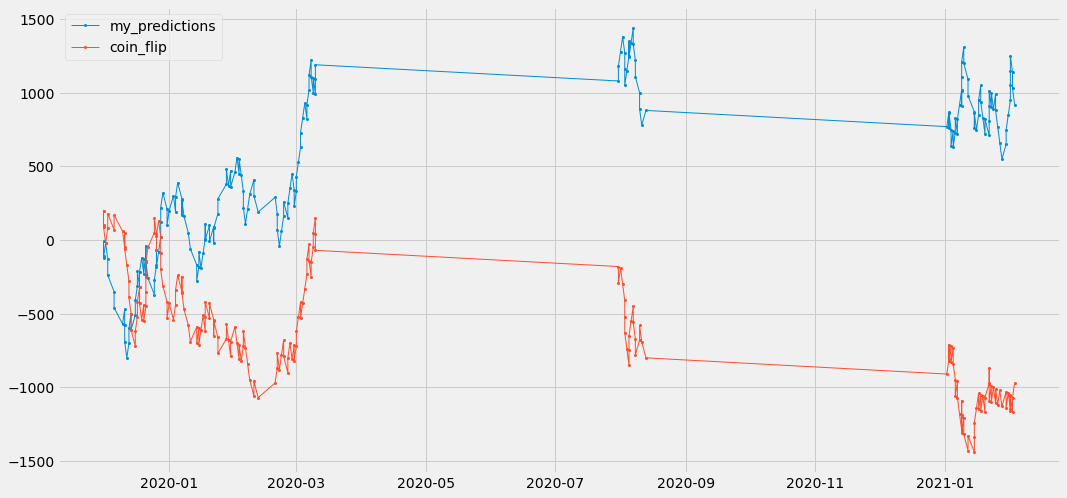

In [142]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(16,8))

ax.plot(over5['date'], over5['cume_profit'], marker='o', linewidth=1, markersize=2, label='my_predictions')
ax.plot(over5['date'], over5['random_cume_profit'], marker='o', linewidth=1, markersize=2, label='coin_flip')

plt.legend()

In [75]:
lr = LogisticRegression(penalty='elasticnet', solver='saga')

lr.fit(X_train, win_train)

lr_preds = lr.predict(X_train)

lr_train_score = lr.score(X_train, win_train)
lr_test_score = lr.score(X_test, win_test)

print("lr_train_score", lr_train_score, 'lr_test_score:', lr_test_score)



lr_train_score 0.7107392825896763 lr_test_score: 0.6175024582104228


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [77]:
X_test

,home_P1_MIN,home_P1_FG3M,home_P1_FG3A,home_P1_FTM,home_P1_FTA,home_P1_OREB,home_P1_DREB,home_P1_REB,home_P1_AST,home_P1_TOV,home_P1_STL,home_P1_BLK,home_P1_BLKA,home_P1_PF,home_P1_PFD,home_P1_PTS,home_P1_PLUS_MINUS,home_P1_E_OFF_RATING,home_P1_OFF_RATING,home_P1_E_DEF_RATING,home_P1_DEF_RATING,home_P1_AST_RATIO,home_P1_TM_TOV_PCT,home_P1_E_USG_PCT,home_P1_E_PACE,home_P1_POSS,home_P1_PIE,home_P1_SPD,home_P1_DIST,home_P1_ORBC,home_P1_DRBC,home_P1_RBC,home_P1_TCHS,home_P1_SAST,home_P1_FTAST,home_P1_PASS,home_P1_CFGM,home_P1_CFGA,home_P1_UFGM,home_P1_UFGA,home_P1_DFGM,home_P1_DFGA,home_P1_FG2M,home_P1_FG2A,home_P1_PTS_2PT,home_P1_PTS_2PT_MR,home_P1_PTS_3PT,home_P1_PTS_FB,home_P1_PTS_OFF_TOV,home_P1_PTS_PAINT,home_P1_AST_2PM,home_P1_UAST_2PM,home_P1_AST_3PM,home_P1_UAST_3PM,home_P2_MIN,home_P2_FG3M,home_P2_FG3A,home_P2_FTM,home_P2_FTA,home_P2_OREB,home_P2_DREB,home_P2_REB,home_P2_AST,home_P2_TOV,home_P2_STL,home_P2_BLK,home_P2_BLKA,home_P2_PF,home_P2_PFD,home_P2_PTS,home_P2_PLUS_MINUS,home_P2_E_OFF_RATING,home_P2_OFF_RATING,home_P2_E_DEF_RATING,home_P2_DEF_RATING,home_P2_AST_RATIO,home_P2_TM_TOV_PCT,home_P2_E_USG_PCT,home_P2_E_PACE,home_P2_POSS,home_P2_PIE,home_P2_SPD,home_P2_DIST,home_P2_ORBC,home_P2_DRBC,home_P2_RBC,home_P2_TCHS,home_P2_SAST,home_P2_FTAST,home_P2_PASS,home_P2_CFGM,home_P2_CFGA,home_P2_UFGM,home_P2_UFGA,home_P2_DFGM,home_P2_DFGA,home_P2_FG2M,home_P2_FG2A,home_P2_PTS_2PT,home_P2_PTS_2PT_MR,...,away_P11_BLK,away_P11_BLKA,away_P11_PF,away_P11_PFD,away_P11_PTS,away_P11_PLUS_MINUS,away_P11_E_OFF_RATING,away_P11_OFF_RATING,away_P11_E_DEF_RATING,away_P11_DEF_RATING,away_P11_AST_RATIO,away_P11_TM_TOV_PCT,away_P11_E_USG_PCT,away_P11_E_PACE,away_P11_POSS,away_P11_PIE,away_P11_SPD,away_P11_DIST,away_P11_ORBC,away_P11_DRBC,away_P11_RBC,away_P11_TCHS,away_P11_SAST,away_P11_FTAST,away_P11_PASS,away_P11_CFGM,away_P11_CFGA,away_P11_UFGM,away_P11_UFGA,away_P11_DFGM,away_P11_DFGA,away_P11_FG2M,away_P11_FG2A,away_P11_PTS_2PT,away_P11_PTS_2PT_MR,away_P11_PTS_3PT,away_P11_PTS_FB,away_P11_PTS_OFF_TOV,away_P11_PTS_PAINT,away_P11_AST_2PM,away_P11_UAST_2PM,away_P11_AST_3PM,away_P11_UAST_3PM,away_P12_MIN,away_P12_FG3M,away_P12_FG3A,away_P12_FTM,away_P12_FTA,away_P12_OREB,away_P12_DREB,away_P12_REB,away_P12_AST,away_P12_TOV,away_P12_STL,away_P12_BLK,away_P12_BLKA,away_P12_PF,away_P12_PFD,away_P12_PTS,away_P12_PLUS_MINUS,away_P12_E_OFF_RATING,away_P12_OFF_RATING,away_P12_E_DEF_RATING,away_P12_DEF_RATING,away_P12_AST_RATIO,away_P12_TM_TOV_PCT,away_P12_E_USG_PCT,away_P12_E_PACE,away_P12_POSS,away_P12_PIE,away_P12_SPD,away_P12_DIST,away_P12_ORBC,away_P12_DRBC,away_P12_RBC,away_P12_TCHS,away_P12_SAST,away_P12_FTAST,away_P12_PASS,away_P12_CFGM,away_P12_CFGA,away_P12_UFGM,away_P12_UFGA,away_P12_DFGM,away_P12_DFGA,away_P12_FG2M,away_P12_FG2A,away_P12_PTS_2PT,away_P12_PTS_2PT_MR,away_P12_PTS_3PT,away_P12_PTS_FB,away_P12_PTS_OFF_TOV,away_P12_PTS_PAINT,away_P12_AST_2PM,away_P12_UAST_2PM,away_P12_AST_3PM,away_P12_UAST_3PM,away_RECORD,prev_cover,prev2_cover
9854,35.623333,1.1,3.8,3.6,4.1,2.0,5.9,7.9,3.9,2.0,0.6,0.4,0.9,2.2,4.5,18.5,8.3,114.15,115.26,102.73,103.81,15.87,8.51,0.2340,99.671,73.4,0.1178,4.134,2.613,4.6,9.0,13.3,67.6,0.2,0.4,45.9,3.7,7.9,3.2,7.3,1.9,2.8,5.8,11.4,11.1,2.0,3.2,2.5,2.3,9.2,3.3,2.2,0.9,0.1,32.855333,1.3,3.1,2.0,2.5,0.9,4.5,5.4,2.5,1.8,1.4,0.4,0.7,2.8,2.6,16.7,4.0,108.49,109.63,102.13,103.18,14.33,10.30,0.1984,100.808,68.3,0.1207,4.214,2.457,2.0,7.9,9.7,54.1,0.4,0.1,38.3,3.1,5.2,3.6,6.9,2.4,3.7,5.4,9.0,10.5,3.3,...,0.0,0.2,0.4,0.3,0.8,-5.0,43.77,47.48,65.87,63.03,5.00,9.00,0.0999,66.165,9.4,-0.0074,1.991,0.263,0.6,0.8,1.4,6.3,0.0,0.0,4.3,0.0,0.4,0.1,0.8,0.2,0.5,0.0,0.7,0.0,0.0,0.6,0.0,0.0,0.0,0.0,0.0,0.2,0.0,1.612167,0.0,0.0,0.0,0.0,0.1,0.0,0.1,0.1,0.2,0.0,0.1,0.0,0.2,0.2,0.0,-2.7,24.10,23.56,45.27,45.88,2.50,5.000000e+00,0.0236,33.043,3.5,-0.0089,1.335,0.125,0.1,0.2,0.2,3.0,0.0,0.0,2.4,0.0,0.2,0.0,0.0,0.2,0.3,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.222222,1.0,0.0
9855,33.594833,1.6,5.1,5.6,9.5,2.7,9.3,12.0,5.7,4.1,1.9

## Neural Network

In [ ]:
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset

In [195]:
X_train_tensor = torch.tensor(X_train.values).float()
y_train_tensor = torch.tensor(point_diff_train.values).view(-1, 1).float()
X_test_tensor = torch.tensor(X_test.values).float()
y_test_tensor = torch.tensor(point_diff_test.values).view(-1,1).float()

X_train_tensor.shape, y_train_tensor.shape

(torch.Size([9144, 1302]), torch.Size([9144, 1]))

In [181]:
len(X_train_tensor)

9144

In [198]:


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, 1)
     
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
    
    
        
net = Net()
print(net)

learning_rate = 0.001

optimizer = optim.Adam(net.parameters(), lr=learning_rate)
loss_function = nn.MSELoss()

epochs = 1000
batch_size= 100

for epoch in range(epochs):
    for i in range(0, len(X_train_tensor), batch_size):
        batch_X = X_train_tensor[i:i+batch_size]
        batch_y = y_train_tensor[i:i+batch_size]


        optimizer.zero_grad()
        
        output = net(batch_X)
        
        loss = loss_function(output, batch_y)
        
        loss.backward()
        
        optimizer.step()
    if epoch % 10 == 0:
        print('epoch {} loss:'.format(i), loss)
    
    
    
print(loss)
        


Net(
  (fc1): Linear(in_features=1302, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
)
epoch {} loss: tensor(114.6783, grad_fn=<MseLossBackward>)
epoch {} loss: tensor(105.0970, grad_fn=<MseLossBackward>)
epoch {} loss: tensor(103.2097, grad_fn=<MseLossBackward>)
epoch {} loss: tensor(106.3956, grad_fn=<MseLossBackward>)
epoch {} loss: tensor(104.8282, grad_fn=<MseLossBackward>)
epoch {} loss: tensor(104.3180, grad_fn=<MseLossBackward>)
epoch {} loss: tensor(103.1282, grad_fn=<MseLossBackward>)
epoch {} loss: tensor(101.5125, grad_fn=<MseLossBackward>)
epoch {} loss: tensor(101.2930, grad_fn=<MseLossBackward>)
epoch {} loss: tensor(100.5083, grad_fn=<MseLossBackward>)
epoch {} loss: tensor(100.0682, grad_fn=<MseLossBackward>)
epoch {} loss: tensor(99.3896, grad_fn=<MseLossBackward>)
epoch {} loss: tensor(99.8303, grad_fn=<MseLossBackward>)
epoch {} loss: tensor(99.3927, grad_fn=<Mse

In [212]:
preds = np.array([])

with torch.no_grad():
    for i in range(len(X_test_tensor)):
        net_out = net(X_test_tensor[i])
        preds = np.append(preds, net_out)
        
        
preds

array([  7.54771948,  -1.03101277,  10.95691872, ...,  13.58555031,
         5.71365213, -11.73660851])

In [222]:
((y_test_tensor - preds)**2).mean()

tensor(260.3629, dtype=torch.float64)

In [270]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, 1)
     
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
    
    
        
net = Net()
print(net)

learning_rate = 0.001

optimizer = optim.Adam(net.parameters(), lr=learning_rate)
loss_function = nn.MSELoss()


Net(
  (fc1): Linear(in_features=1302, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
)


In [271]:
def fwd_pass(X, y, train=False):
    if train:
        net.zero_grad()
    outputs = net(X)
    
    mse = ((outputs - y)**2).mean()
    
    if train:
        loss.backward()
        optimizer.step()
        
    return mse, loss
    
    

In [272]:

def test(size=32):

    random_start = np.random.randint(0, len(X_test_tensor) - size)
    X, y = X_test_tensor[random_start:random_start+size], y_test_tensor[random_start:random_start+size]
    
    with torch.no_grad():    
        val_mse, val_loss = fwd_pass(X, y)
        
    return val_mse, val_loss

val_mse, val_loss = test(size=32)
print(val_mse, val_loss)

tensor(249.0020) tensor(88.1263, grad_fn=<MseLossBackward>)


In [273]:
import time

model_name = "model-{}".format(int(time.time()))
net = Net()

def train():
    batch_size = 100
    epochs = 100
#     with open("model.log", "a") as f:
    for epoch in range(epochs):
        for i in range(0, len(X_train_tensor), batch_size):
            batch_X = X_train_tensor[i:i+batch_size]
            batch_y = y_train_tensor[i:i+batch_size]

            mse, loss = fwd_pass(batch_X, batch_y, train=True)

            if i % 10 == 0:
                val_mse, val_loss = fwd_pass(size=100)
                print("training_loss:", mse, loss)
                print("validation_loss:", val_mse, val_loss)
                    
#                     f.write(f"{model_name}, {round(time.time(), 3)}, {round(float(loss),4)}")
                    
train()

RuntimeError: Trying to backward through the graph a second time, but the buffers have already been freed. Specify retain_graph=True when calling backward the first time.

In [237]:
test_idx = X_test.index

betting_results = full_df.loc[test_idx, ['date', 'spread']]
betting_results['actual_point_diff'] = point_diff_test
betting_results['prediction'] = preds
betting_results['bet_home_team'] = (betting_results['prediction'] + betting_results['spread'] > 0).astype(int)

betting_results['home_covered'] = (betting_results['actual_point_diff'] + betting_results['spread'] > 0).astype(int)
betting_results['profit'] = betting_results.apply(lambda row: 100 if row['bet_home_team'] == row['home_covered'] else -110, axis=1)
betting_results['cume_profit'] = betting_results['profit'].expanding().sum()

betting_results['random_profit'] = np.random.choice([100, -110], betting_results.shape[0])
betting_results['random_cume_profit'] = betting_results['random_profit'].expanding().sum()
betting_results['prediction+spread'] = round(betting_results['prediction'] + betting_results['spread'], 2)



In [238]:
betting_results['profit'].value_counts()

-110    515
 100    502
Name: profit, dtype: int64

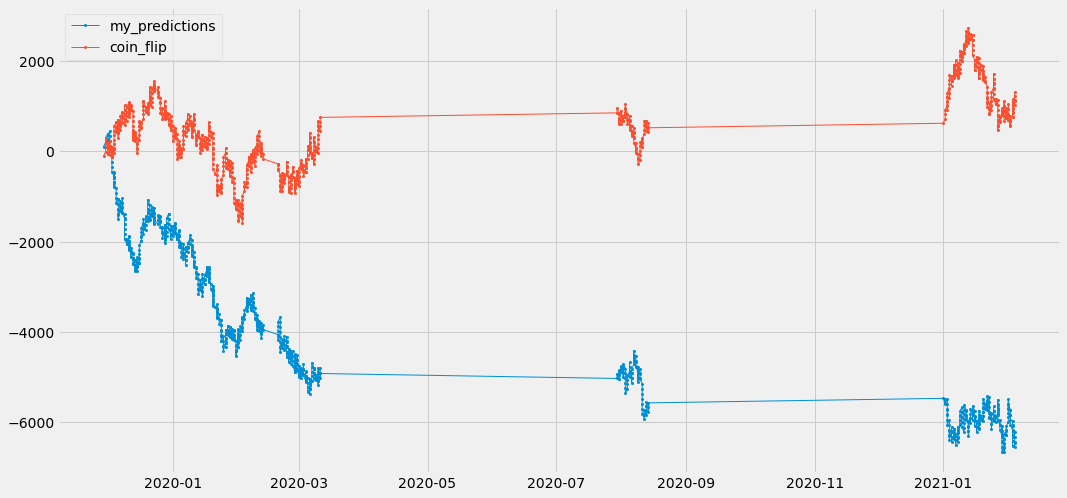

In [239]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(16,8))

ax.plot(betting_results['date'], betting_results['cume_profit'], marker='o', linewidth=1, markersize=2, label='my_predictions')
ax.plot(betting_results['date'], betting_results['random_cume_profit'], marker='o', linewidth=1, markersize=2, label='coin_flip')

plt.legend()